In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import re
import math
import copy

In [2]:
# 预定义的变量
save_path = 'D:\\sorf_models\\model\\tests\\model_saves' # 储存模型结果的文件夹，以\\结尾

# 模型超参数
window_size = 51  # 每次输入的序列长度，为奇数,且至少为5
lr_00 = lr = 0.8
momentum = 0.8
dropout = 0
batch_size = 32
num_layers = 2  # LSTM层数
hidden_dim = 128  # LSTM隐藏层大小
proj_size = 64  # LSTM映射层大小
lr_epoch_decay = 0.997  # 每个epoch的lr衰减
inspect_loss_decay = 0.5  # 每当loss下降为原来的inspect_loss_decay，便更新一次lr
lr_adapt_decay = 0.8  # 更新lr为原来的lr_adapt_decay
inspect_num = 3  # 以inspect_num个batch为单位判定模型收敛程度，要么1要么2
weight_scale=0.02
loss_ratio=0.5
TIS_max_num=40

j = 'all_10'

# writer
run_header="train_2_15"

In [3]:
#读取fasta
def read_fasta(input): #用def定义函数read_fasta()，并向函数传递参数用变量input接收
    with open(input,'r') as f: # 打开文件
        fasta = {} # 定义一个空的字典
        for line in f:
            line = line.strip() # 去除末尾换行符
            if line[0] == '>':
                header = line[1:]
            else:
                sequence = line
                fasta[header] = fasta.get(header,'') + sequence
    return fasta
fa=read_fasta('gencode.v38.annotation.gff3_gffreadto_simple_plane_new.fa')
def find_TIS(transcript,prints=False):
    seq=fa[transcript]
    pattern=re.compile(r'(?=(ATG|TTG|CTG|GTG|AAG|ACG|AGG|ATA|ATT|ATC))')
    it=re.finditer(pattern,seq)
    TIS=[(i.group(1),i.span()[0]) for i in it]
    if prints==True:
        index=transcripts.index(transcript)
        vector=vectors[index]
        print('transcript:',transcript)
        print('length:',len(vector))
        print('TPM:',TPMs[index])
        print('normalized sum read count:',sum(vector))
        print('raw peak read count:',np.max(raw_vectors[index]))
        print('max peak at position',np.argmax(vector))
    return TIS[0:TIS_max_num]

In [4]:
# 读取和处理数据：
with open('final_transcripts_all5.pkl','rb') as file:
    transcripts=pickle.load(file)
with open('final_vectors_all5.pkl','rb') as file:
    vectors=pickle.load(file)
with open('final_raw_vectors_all5.pkl','rb') as file:
    raw_vectors=pickle.load(file)
with open('final_TPMs_all5.pkl','rb') as file:
    TPMs=pickle.load(file)
print(len(TPMs))
meta=pd.read_csv('gencode_transcript_meta_new.txt',sep='\t',header=None)
meta.columns=['ID','Parent','transcript_id','gene_id','gene_type','gene_name','transcript_type','transcript_name','ccdsid','mRNA_start_NF','mRNA_end_NF','cds_start_NF','cds_end_NF']
used_meta=pd.DataFrame(data=transcripts,columns=['ID']).merge(meta,on='ID',how='left')
print('mRNA_start_NF count:',np.sum(~(used_meta['mRNA_start_NF'].values.astype('<U32')=='nan')))
remove=[i for i in range(len(transcripts)) if used_meta['mRNA_start_NF'].values[i]=='mRNA_start_NF']
print(remove)
print([transcripts[i] for i in remove])
transcripts=[transcripts[i] for i in range(len(transcripts)) if i not in remove]
vectors=[vectors[i] for i in range(len(vectors)) if i not in remove]
raw_vectors=[raw_vectors[i] for i in range(len(raw_vectors)) if i not in remove]
TPMs=[TPMs[i] for i in range(len(TPMs)) if i not in remove]
print(len(TPMs))

padding_size = int(window_size / 2)
padded_seq_list=["P"*padding_size+fa[i]+"P"*padding_size for i in transcripts]
dict = {'P': np.array([1, 0, 0, 0, 0]),
        'A': np.array([0, 1, 0, 0, 0]),
        'G': np.array([0, 0, 1, 0, 0]),
        'C': np.array([0, 0, 0, 1, 0]),
        'T': np.array([0, 0, 0, 0, 1])
        }

def is_validate(k,sig_ratio_cutoff=2):
    if vectors[iii][k-padding_size]==0:
        return 0
    else:
        background_pos=[i for i in set(range(k-3,k+4))-set(pos3) if i>=padding_size and i<=len(vectors[iii])+padding_size-1]
        if len(background_pos)==0:
            print('Error: background_pos len=0 for iii='+str(iii)+' and position='+str(k-padding_size))
        background_signal=np.mean(vectors[iii][[i-padding_size for i in background_pos]])
        if background_signal==0:
            return 1
        else:
            signal_ratio=vectors[iii][k-padding_size]/background_signal
            if signal_ratio>=sig_ratio_cutoff:
                return 1
            else:
                return 0
    
def form_target(k,left_diff,right_diff):
    if left_diff>=3:
        left_value=vectors[iii][k-padding_size-1]
    elif left_diff==1:
        left_value=0
    elif left_diff==0 and k==padding_size:
        left_value=0
    elif left_diff==0 and k>padding_size:
        left_value=vectors[iii][k-padding_size-1]
    else:
        left_value=0.5*vectors[iii][k-padding_size-1]
    if right_diff>=3 or right_diff==0:
        right_value=vectors[iii][k-padding_size+1]
    elif right_diff==1:
        right_value=0
    else:
        right_value=0.5*vectors[iii][k-padding_size+1]
    return left_value+vectors[iii][k-padding_size]+right_value

def ifleftequalzero(j):
    if j==0:
        return 0
    else:
        return pos[j]-pos[j-1]

def ifrightequalmax(j):
    if j==(len(pos)-1):
        return 0
    else:
        return pos[j+1]-pos[j]

1578
mRNA_start_NF count: 9
[503, 747, 1305, 1391, 1450, 1472, 1473, 1491, 1496]
['ENST00000293860.6', 'ENST00000329099.4', 'ENST00000399815.2', 'ENST00000486442.6', 'ENST00000548861.2', 'ENST00000569622.5', 'ENST00000570054.3', 'ENST00000594769.5', 'ENST00000597961.1']
1569


In [5]:
def inspect_index(inspect_index):
    print('test:',inspect_index)
    print(transcripts[inspect_index])
    print('TPM:',TPMs[inspect_index])
    print('sum normalized counts:',sum(vectors[inspect_index]))
    np.savetxt('final_true_vs_predicts\\inspect.txt',vectors[inspect_index],header=transcripts[inspect_index])

In [6]:
# #测试：
# iii=1326
# ii=padded_seq_list[iii]
# print(fa[transcripts[1326]])
# pattern=re.compile(r'(?=(ATG|TTG|CTG|GTG|AAG|ACG|AGG|ATA|ATT|ATC))')
# it=re.finditer(pattern,ii)
# pos3=[i.span()[0] for i in it][0:53]
# pos2=pos3[0:51]
# pos=pos2[0:50]
# if len(pos2)==len(pos):
#     pos2=pos2+[pos2[len(pos2)-1]+20]
# inspect_index(iii)
# print(list(zip(find_TIS(transcripts[iii]),[is_validate(pos[j]) for j in range(len(pos))])))
# print(torch.tensor([form_target(pos[j],ifleftequalzero(j),ifrightequalmax(j))*is_validate(pos[j]) for j in range(len(pos))]))
# validate_pos=[i for i in pos if is_validate(i)==1]
# all_pos_count_middle=set([i-padding_size for i in validate_pos])
# all_pos_count_left=set([max(i-padding_size-1,0) for i in validate_pos])
# all_pos_count_right=set([i-padding_size+1 for i in validate_pos])
# all_pos_count=all_pos_count_middle.union(all_pos_count_left,all_pos_count_right)
# print(all_pos_count)
# print(sum([raw_vectors[iii][i] for i in all_pos_count]))
# print(torch.tensor([1-math.e**(-weight_scale*sum([raw_vectors[iii][i] for i in all_pos_count]))]*len(pos)))
# pos1=[padding_size]+pos
# print(torch.stack([torch.tensor([pos1[i+1]-pos1[i] for i in range(len(pos1)-1)]),torch.tensor([pos2[i+1]-pos2[i] for i in range(len(pos2)-1)])],1))

The length of seq data is:  1563
tensor([[[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [0, 0, 0, 0, 1],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         ...,
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1],
         [0, 1, 0, 0, 0]],

        ...,

        [[0, 0, 0, 0, 1],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0],
         ...,
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1],
         [0, 1, 0, 0, 0]],

        [[0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0],
         ...,
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1],
         [0, 0, 1, 0, 0]],

        [[0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0],
         ...,
 

<AxesSubplot:ylabel='Count'>

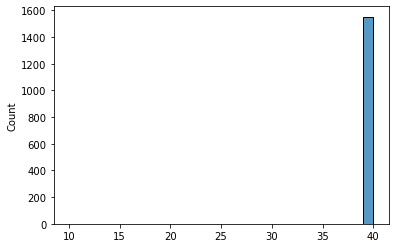

In [7]:
seq = []
target=[]
weight=[]
dis=[]
for iii in range(len(padded_seq_list)):
    ii=padded_seq_list[iii]
    pattern=re.compile(r'(?=(ATG|TTG|CTG|GTG|AAG|ACG|AGG|ATA|ATT|ATC))')
    it=re.finditer(pattern,ii)
    pos3=[i.span()[0] for i in it][0:(TIS_max_num+3)]
    pos2=pos3[0:(TIS_max_num+1)]
    pos=pos2[0:TIS_max_num]
    if len(pos2)==len(pos):
        pos2=pos2+[pos2[len(pos2)-1]+20]
    seq.append(torch.stack([torch.tensor([dict[j] for j in list(ii[(p-padding_size):(p+padding_size+1)])], dtype=torch.long) for p in pos]))    
    target.append(torch.tensor([form_target(pos[j],ifleftequalzero(j),ifrightequalmax(j))*is_validate(pos[j]) for j in range(len(pos))]))
    validate_pos=[i for i in pos if is_validate(i)==1]
    all_pos_count_middle=set([i-padding_size for i in validate_pos])
    all_pos_count_left=set([max(i-padding_size-1,0) for i in validate_pos])
    all_pos_count_right=set([i-padding_size+1 for i in validate_pos])
    all_pos_count=all_pos_count_middle.union(all_pos_count_left,all_pos_count_right)
    weight.append(torch.tensor([1-math.e**(-weight_scale*sum([raw_vectors[iii][i] for i in all_pos_count]))]*len(pos)))
    pos1=[padding_size]+pos
    dis.append(torch.stack([torch.tensor([pos1[i+1]-pos1[i] for i in range(len(pos1)-1)]),torch.tensor([pos2[i+1]-pos2[i] for i in range(len(pos2)-1)])],1))

remove=[i for i in range(len(weight)) if weight[i][0]==0]
seq = [seq[i] for i in range(len(seq)) if i not in remove]
target=[target[i] for i in range(len(target)) if i not in remove]
weight=[weight[i] for i in range(len(weight)) if i not in remove]
dis=[dis[i] for i in range(len(dis)) if i not in remove]
transcript=[transcripts[i] for i in range(len(transcripts)) if i not in remove]

print("The length of seq data is: ", len(seq))
print(seq[0])
print(seq[0].shape)
show=find_TIS(transcript[0])
print([(show[i][0],show[i][1],target[0][i],dis[0][i,0],dis[0][i,1]) for i in range(len(target[0]))])
print(target[0].shape)
print('weight:',weight[0][0:10])
sns.histplot(np.array([i.shape[0] for i in seq]),binwidth=1)

<AxesSubplot:xlabel='Sum raw read count', ylabel='Weight'>

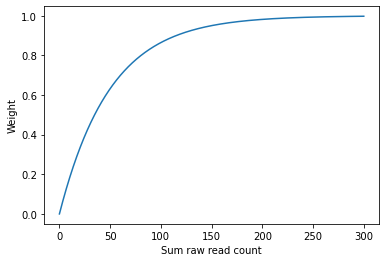

In [8]:
x=np.arange(0,300,0.01)
y=1-math.e**(-weight_scale*x)
sns.lineplot(data=pd.DataFrame({'Weight': y,'Sum raw read count': x}),x='Sum raw read count',y='Weight')

In [9]:
# #数据预处理——归一化、权重
# target0=copy.deepcopy(target)
# outliers_index=[i for i in range(len(target)) if torch.sum(target[i])>15]
# for i in outliers_index:
#     target[i]=target[i]*15/sum(target[i])

# target=[i*math.log(torch.sum(i)+1)/torch.sum(i) for i in target]
# plotdata={'Sum label signal': np.array([torch.sum(i) for i in target0]+[torch.sum(i) for i in target]),
#          'col': ['before']*len(target0)+['after']*len(target)}

In [10]:
# sns.displot(data=plotdata,x='Sum label signal',col='col',facet_kws={'sharex': False},common_bins=False).savefig('new_standardize_target_before_after.pdf')

In [11]:
# target0=copy.deepcopy(target)
# target=[i/torch.sum(i) for i in target]
# sns.displot(data=np.array([sum(i) for i in target0]))

In [12]:
dis0=dis
sqrt_scale=torch.sqrt(torch.var(torch.cat(dis).flatten(0).type(torch.DoubleTensor),unbiased=False))
print("standardization ratio:",sqrt_scale)
dis=[i/sqrt_scale for i in dis]
plotdata={'TIS distance': np.concatenate((np.array(torch.cat([i[:,0] for i in dis0],0)),np.array(torch.cat([i[:,0] for i in dis],0)))),
         'col': ['before']*len(np.array(torch.cat([i[:,0] for i in dis0],0)))+['after']*len(np.array(torch.cat([i[:,0] for i in dis],0)))}

standardization ratio: tensor(7.4752, dtype=torch.float64)


In [13]:
# plotdata=pd.DataFrame(plotdata)
# fig, ax = plt.subplots(1,2,figsize=(15, 5))
# sns.histplot(plotdata[plotdata.col=='before'],x='TIS distance',binwidth=1,ax=ax[0])
# sns.histplot(plotdata[plotdata.col=='after'],x='TIS distance',binwidth=1/sqrt_scale-0.00001,ax=ax[1])
# ax[0].set_title('Before')
# ax[1].set_title('After')
# fig.savefig('new_standardize_distance_before_after.pdf')

In [14]:
#检查是否有nan值：
print([i for i in range(len(target)) if torch.sum(torch.isnan(target[i]))!=0])
print(transcript[1326])
print(target[1326])
print([i for i in range(len(transcripts)) if transcripts[i]==transcript[1326]])
print(len(vectors[1326]))

[]
ENST00000418945.2
tensor([0.0000, 0.0000, 0.0749, 0.0000, 0.0000, 0.0000, 0.0000, 1.0173, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0749, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0926, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0749, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1617, 0.2601], dtype=torch.float64)
[1329]
4887


In [15]:
class MyLSTM(nn.Module):
    def __init__(self, dropout, num_layers, hidden_dim, proj_size, input_dim=62):
        # 即表示每一个window（31个碱基）对应一个cell，再加上一个frame indicator
        super(MyLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (5,3), padding=(2,1))
        self.conv2 = nn.Conv2d(16, 16, (5,3), padding=(2,1))
        #self.conv3 = nn.Conv2d(16, 16, (5,3), padding=(2,1))
        #self.pool = nn.MaxPool2d(2, 2)
        self.fc0 = nn.Linear(16 * 5 * window_size, input_dim)
        #self.fc00 = nn.Linear(64, 32)
        #self.fc000 = nn.Linear(4 * window_size * 4, window_size * 4)
        self.rnn = nn.LSTM(input_size=input_dim+2, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, int(hidden_dim/2))
        #self.fc2 = nn.Linear(proj_size, int(proj_size/2))
        self.fc2 = nn.Linear(int(hidden_dim/2), 1)
        #self.fc4 = nn.Linear(int(proj_size/4), 1)
        self.lrelu1 = nn.LeakyReLU(0.05)
        self.lrelu2 = nn.LeakyReLU(0.05)
        #self.thresh = nn.Threshold(0.01, 0)
        #self.shrink = nn.Hardshrink(0.01)

    def forward(self, x, sizes, diss):
        output = F.relu(self.conv1(x))  # (sum_seq_len, 1, window_size, 5)
        output = F.relu(self.conv2(output))  # (sum_seq_len, 16, window_size, 5)
        #output = self.sigmoid(self.conv2(output))  # in_output: (sum_seq_len, 4, window_size, 4)
        output = F.relu(self.fc0(torch.flatten(output, 1))) # (sum_seq_len, 16*window_size*5)
        #output = F.relu(self.fc00(output))  # (sum_seq_len, 62)
        #output = self.lrelu(self.fc000(output))
        output = torch.cat((output, diss), 1)  # (sum_seq_len, 62)
        output = nn.utils.rnn.PackedSequence(data=output, batch_sizes=sizes)  # (sum_seq_len, 64)
        output, _ = self.rnn(output)  # (packed_len, 64)
        output = self.lrelu1(output.data)  # (sum_seq_len, 64)
        #output = F.relu(self.fc0(output))
        output = self.lrelu2(self.fc1(output))  # (sum_seq_len, 64)
        #output = F.relu(self.fc1(output))  # in_output: (sum_seq_len, proj_size)
        output = self.fc2(output).squeeze()  # (sum_seq_len, 32)
        #output = self.fc4(output).squeeze()  # in_output: (sum_seq_len, proj_size/4)
        output = nn.utils.rnn.PackedSequence(data=output, batch_sizes=sizes)  # (packed_len)
        output = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)  # (batch_size, max_seq_length)
        return output[0]

# 设定随机数种子
torch.manual_seed(201)
torch.cuda.manual_seed(88)

# 十折交叉验证+训练
class MyDataset(Dataset):
    def __init__(self, inputset, targetset, weightset, disset, transcriptset, k, overall_size, state='train'):
        if state == 'train':
            index2 = list(range(int((k % 10) * overall_size / 10))) + \
                     list(range(int((k % 10 + 1) * overall_size / 10), overall_size))
            self.inputset = [inputset[k] for k in index2]
            self.targetset = [targetset[k] for k in index2]
            self.weightset = [weightset[k] for k in index2]
            self.disset = [disset[k] for k in index2]
            self.transcriptset = [transcriptset[k] for k in index2]
        if state == 'test':
            index2 = list(range(int((k % 10) * overall_size / 10), int((k % 10 + 1) * overall_size / 10)))
            self.inputset = [inputset[k] for k in index2]
            self.targetset = [targetset[k] for k in index2]
            self.weightset = [weightset[k] for k in index2]
            self.disset = [disset[k] for k in index2]
            self.transcriptset = [transcriptset[k] for k in index2]
        if state == 'all':
            self.inputset = inputset
            self.targetset = targetset
            self.weightset = weightset
            self.disset = disset
            self.transcriptset = transcriptset

    def __getitem__(self, idx):
        input = self.inputset[idx]
        label = self.targetset[idx]
        weights = self.weightset[idx]
        diss = self.disset[idx]
        transcriptt = self.transcriptset[idx]
        return input, label, weights, diss, transcriptt

    def __len__(self):
        return len(self.targetset)

# 随机打乱原始数据集
np.random.seed(3)
index = np.arange(len(target))
np.random.shuffle(index)
index1 = index.tolist()
target_all = [target[i] for i in index1]
seq_all = [seq[i] for i in index1]
weight_all = [weight[i] for i in index1]
dis_all = [dis[i] for i in index1]
transcript_all = [transcript[i] for i in index1]

overall_size = len(target)
print("overall dataset size: ", overall_size)
cuda_avail = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(cuda_avail)
epoch_num = 20
write_every = 1

# 由于每个sample长度不一，需要自定义Dataloader的collate_fn:
def collate_fn_padd(batch):
    batch_target = [i[1] for i in batch]
    target_lengths = torch.tensor([t.shape[0] for t in batch_target])
    batch_seq = [i[0] for i in batch]
    batch_weight = [i[2] for i in batch]
    batch_dis = [i[3] for i in batch]
    batch_trans = [i[4] for i in batch]
    ## padd
    target_lengths, idx = target_lengths.sort(0, descending=True)
    batch_seq = [batch_seq[i] for i in idx]
    batch_target = [batch_target[i] for i in idx]
    batch_weight = [batch_weight[i] for i in idx]
    batch_dis = [batch_dis[i] for i in idx]
    batch_trans = [batch_trans[i] for i in idx]
    batch_seq = [t.type(torch.float).to(device) for t in batch_seq]
    batch_target = [t.type(torch.float).to(device) for t in batch_target]
    batch_weight = [t.type(torch.float).to(device) for t in batch_weight]
    batch_dis = [t.type(torch.float).to(device) for t in batch_dis]

    batch_seq = pad_sequence(batch_seq, batch_first=True)  # (batch_size, max_seq_length, window_size, 4)
    batch_seq = pack_padded_sequence(input=batch_seq, lengths=target_lengths, batch_first=True)
    # (sum_seq_length, window_size, 4)
    batch_weight = pad_sequence(batch_weight, batch_first=True)
    #batch_weight = pack_padded_sequence(input=batch_weight, lengths=target_lengths, batch_first=True).data
    # (sum_seq_length, 3)
    batch_target = pad_sequence(batch_target, batch_first=True)  # (batch_size, max_seq_length)
    #batch_target = pack_padded_sequence(input=batch_target, lengths=target_lengths, batch_first=True).data
    # (sum_seq_len)
    batch_dis = pad_sequence(batch_dis, batch_first=True)  # (batch_size, max_seq_length)
    batch_dis = pack_padded_sequence(input=batch_dis, lengths=target_lengths, batch_first=True).data
    return torch.unsqueeze(batch_seq.data, 1), batch_seq.batch_sizes, batch_target, batch_weight, batch_dis, batch_trans

overall dataset size:  1563
True


In [16]:
print(index1[0:5])
print(transcript_all[0:5])

[193, 471, 1053, 70, 804]
['ENST00000246792.4', 'ENST00000286548.9', 'ENST00000371443.6', 'ENST00000220244.7', 'ENST00000338492.9']


In [17]:
test0=torch.tensor([[1,2,3],[2,3,4],[5,7,6]])
print(test0)
test,_=torch.max(test0,1,keepdim=True)
test1=torch.sum(torch.abs(test0),1,keepdim=True)
print(test)
print(test0/test)
print(test1)
print(test0/test1)

tensor([[1, 2, 3],
        [2, 3, 4],
        [5, 7, 6]])
tensor([[3],
        [4],
        [7]])
tensor([[0.3333, 0.6667, 1.0000],
        [0.5000, 0.7500, 1.0000],
        [0.7143, 1.0000, 0.8571]])
tensor([[ 6],
        [ 9],
        [18]])
tensor([[0.1667, 0.3333, 0.5000],
        [0.2222, 0.3333, 0.4444],
        [0.2778, 0.3889, 0.3333]])


In [18]:
test1=pad_sequence([torch.tensor([1,2,3,4,5]),torch.tensor([1,2,3,4]),torch.tensor([1,2,3,4]),torch.tensor([1,2])], batch_first=True)
print(test1)
test2=pack_padded_sequence(input=test1, lengths=torch.tensor([5,4,4,2]), batch_first=True)
print(test2.data)
print(nn.utils.rnn.pad_packed_sequence(test2, batch_first=True)[0])
print(nn.utils.rnn.PackedSequence(data=test2.data, batch_sizes=torch.tensor([5,4,4,2])).data)

tensor([[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 0],
        [1, 2, 3, 4, 0],
        [1, 2, 0, 0, 0]])
tensor([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5])
tensor([[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 0],
        [1, 2, 3, 4, 0],
        [1, 2, 0, 0, 0]])
tensor([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5])


In [19]:
writer = SummaryWriter(run_header)
writer_title='run_'+str(j)
MyData = MyDataset(inputset=seq_all, targetset=target_all, weightset=weight_all, disset=dis_all, transcriptset=transcript_all, k=j, overall_size=overall_size, state='all')
Myloader = torch.utils.data.DataLoader(MyData, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn_padd, drop_last=True)

Mymodel = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel.to(device)
print("Is cuda available: ", cuda_avail)

def my_loss(outputs,labels,weights,sum_seq_len,loss_ratio):
    outputs_sum=torch.sum(torch.abs(outputs),1,keepdim=True)
    outputs1=outputs/outputs_sum
    labels_sum=torch.sum(labels,1,keepdim=True)
    labels=labels/labels_sum
    return torch.sum(weights*((1-loss_ratio)*(labels - outputs)**2+loss_ratio*(labels - outputs1)**2))/sum_seq_len

#criterion = nn.MSELoss(reduction='sum')
criterion = my_loss
optimizer = optim.SGD(Mymodel.parameters(), lr=lr, momentum=momentum)
jj = 0
running_loss = []
val_loss=[]
MyvalData = MyDataset(inputset=seq_all, targetset=target_all, weightset=weight_all, disset=dis_all, transcriptset=transcript_all, k=j, overall_size=overall_size, state='all')
Myvalloader = torch.utils.data.DataLoader(MyvalData, batch_size=len(MyvalData), shuffle=True, num_workers=0, collate_fn=collate_fn_padd, drop_last=True)
iter0=iter(enumerate(Myvalloader, 0))
iii, val_batch=next(iter0)
val_inputs, val_sizes, val_labels, val_weights, val_diss, val_transcripts = val_batch
val_label_mTIS_indices=torch.argmax(val_labels,dim=1)

epoch = 0
inspect = False
initialize = True
converge_level = 0
sigma_index = 0
val_min_loss = math.inf
inspect_loss = 0

Is cuda available:  True


In [20]:
# iter0=iter(enumerate(Myloader))
# i,test=next(iter0)
# test_input,test_batch_size,test_label,test_weight,test_dis,_=test
# #print(sum(test_label))
# print('test_batch_size:',test_batch_size)
# print('torch.sum(test_batch_size):',torch.sum(test_batch_size))
# print('test_input.shape:',test_input.shape)
# print('torch.squeeze(test_input).shape:',torch.squeeze(test_input).shape)
# print('test_label.shape:',test_label.shape)
# print('test_weight:',test_weight)
# print('test_dis:',test_dis)
# print('test_dis.shape:',test_dis.shape)
#print(test_input[50:500])
#print(test_label[50:500])

In [21]:
def save_mymodel():
    state = {
        'epoch': epoch,
        'jj': jj,
        'converge_level': converge_level,
        'running_loss': running_loss,
        'inspect_loss': inspect_loss,
        'state_dict': Mymodel.state_dict(),
        'optimizer': optimizer.state_dict(),
        'j': j,
        'loss_ratio': loss_ratio,
        'sigma_index': sigma_index
    }
    os.makedirs(save_path + "\\"+run_header, exist_ok=True)
    torch.save(state, save_path + "\\"+run_header+"\\"+writer_title+".pkl")
def save_mTIS_prediction_data():
    np.savetxt('mTIS_identity\\val_transcripts_'+str(j)+'.txt',np.array(val_transcripts),fmt="%s",header='')
    np.savetxt('mTIS_identity\\val_weights_'+str(j)+'.txt',np.array(val_weights[:,0].cpu()),header='')
    val_label_mTIS_indices=torch.argmax(val_labels,dim=1)
    np.savetxt('mTIS_identity\\val_label_mTIS_indices_'+str(j)+'.txt',np.array(val_label_mTIS_indices.cpu()),fmt="%d",header='')
    val_output_mTIS_indices=torch.argmax(val_outputs,dim=1)
    np.savetxt('mTIS_identity\\val_output_mTIS_indices_'+str(j)+'.txt',np.array(val_output_mTIS_indices.cpu()),fmt="%d",header='')
    val_label_mTIS_codons=[find_TIS(val_transcripts[i])[val_label_mTIS_indices[i]][0] for i in range(len(val_transcripts))]
    np.savetxt('mTIS_identity\\val_label_mTIS_codons_'+str(j)+'.txt',np.array(val_label_mTIS_codons),fmt="%s",header='')
    val_output_mTIS_codons=[find_TIS(val_transcripts[i])[val_output_mTIS_indices[i]][0] for i in range(len(val_transcripts))]
    np.savetxt('mTIS_identity\\val_output_mTIS_codons_'+str(j)+'.txt',np.array(val_output_mTIS_codons),fmt="%s",header='')
    val_label_mTIS_positions=[find_TIS(val_transcripts[i])[val_label_mTIS_indices[i]][1] for i in range(len(val_transcripts))]
    np.savetxt('mTIS_identity\\val_label_mTIS_positions_'+str(j)+'.txt',np.array(val_label_mTIS_positions),fmt="%d",header='')
    val_output_mTIS_positions=[find_TIS(val_transcripts[i])[val_output_mTIS_indices[i]][1] for i in range(len(val_transcripts))]
    np.savetxt('mTIS_identity\\val_output_mTIS_positions_'+str(j)+'.txt',np.array(val_output_mTIS_positions),fmt="%d",header='')
    np.savetxt('mTIS_identity\\final_mTIS_accuracy_'+str(j)+'.txt',np.array([mTIS_accuracy.cpu()]),fmt="%.6f")
    np.savetxt('mTIS_identity\\final_val_loss_'+str(j)+'.txt',np.array([val_min_loss]),fmt="%.6f")
def high_mTIS_prediction(weights_cutoff=0.75):
    with torch.no_grad():
        mindex=[i for i in range(len(val_transcripts)) if val_weights[i,0]>weights_cutoff]
        val_high_outputs=val_outputs[mindex]
        val_high_labels=val_labels[mindex]
        val_high_label_argmax=torch.argmax(val_high_labels,dim=1)
        val_high_output_argmax=torch.argmax(val_high_outputs,dim=1)
    return sum(val_high_label_argmax==val_high_output_argmax)/len(val_high_label_argmax)

In [23]:
# 人控训练：每执行一次为一个epoch，觉得训练完成后再继续后面的步骤
for ss in range(90):
    Mymodel.train()
    for ii, batch in enumerate(Myloader, 0):
        inputs, sizes, labels, weights, diss, _ = batch
        optimizer.zero_grad()
        outputs = Mymodel(x=inputs, sizes=sizes, diss=diss)
        loss = criterion(outputs, labels, weights, torch.sum(sizes), loss_ratio)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())

        if initialize and epoch == 0 and ii == 3 * inspect_num + 20:
            inspect_loss = sum(running_loss[-inspect_num:]) / inspect_num
            inspect = True
            initialize = False
            print("inspect loss cutoff initialized as: " + str(inspect_loss))
            print("first inspect loss cutoff: " + str(inspect_loss_decay * inspect_loss))

        if jj % write_every == write_every - 1:
            writer.add_scalars(writer_title, {'loss': sum(running_loss[-write_every:]) / write_every,
                                               'lr': 0.01*optimizer.param_groups[0]['lr'],
                                               'sigma': 0.01*loss_ratio}, jj)
#            writer.add_scalar(writer_title + "_lr", optimizer.param_groups[0]['lr'], jj)
            print("[%s]-[%d]-[%d] lr=[%r] loss=[%.3f]" % (
            j, epoch + 1, ii + 1, optimizer.param_groups[0]['lr'], sum(running_loss[-write_every:]) / write_every))
        jj += 1
        
        #if sum(running_loss[-1:]) > 1e+5:
        #    with torch.no_grad():
        #        print(outputs[0:500])
        #        print(labels[0:500])
        # loss每降低一半，相应lr也调整为原来的一半
        if inspect:
            if sum(running_loss[-inspect_num:]) / inspect_num < inspect_loss_decay * inspect_loss:
                lr_0 = lr
                lr *= lr_adapt_decay
                for param_group in optimizer.param_groups:
                    param_group["lr"] = lr
                inspect_loss *= inspect_loss_decay
                converge_level += 1
                print("lr adapted to " + str(lr_adapt_decay) + "*" + str(lr_0) + "=" + str(lr))
                print("new inspect loss cutoff: " + str(inspect_loss_decay * inspect_loss))
                if loss_ratio<0.95 and sigma_index<2:
                    loss_ratio = loss_ratio+(1-loss_ratio)*0.7
                    sigma_index += 1
#             if sum(running_loss[-2:])/2 > 2 * inspect_loss / inspect_loss_decay:
#                 lr *= 0.1
#                 for param_group in optimizer.param_groups:
#                     param_group["lr"] = lr
#                 break
    # 查看output和label：
    with torch.no_grad():
        print(outputs[0:500])
        print(labels[0:500])
    # 每个epoch的lr下降：
    lr *= lr_epoch_decay
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    epoch += 1
    #每个epoch计算一次验证集loss，并记录：
    Mymodel.eval()
    with torch.no_grad():
        val_outputs = Mymodel(x=val_inputs, sizes=val_sizes, diss=val_diss)
#         loss = criterion(val_outputs, val_labels, val_weights, torch.sum(val_sizes), loss_ratio)
#         val_loss.append(loss.item())
        mTIS_accuracy=sum(val_label_mTIS_indices==torch.argmax(val_outputs,dim=1))/len(val_label_mTIS_indices)
    writer.add_scalars(writer_title,{'mTIS_accuracy': 0.01*mTIS_accuracy,'high_confidence_mTIS_accuracy': 0.01*high_mTIS_prediction()},jj)

[all_10]-[1]-[1] lr=[0.8] loss=[0.009]
[all_10]-[1]-[2] lr=[0.8] loss=[0.007]
[all_10]-[1]-[3] lr=[0.8] loss=[0.008]
[all_10]-[1]-[4] lr=[0.8] loss=[0.008]
[all_10]-[1]-[5] lr=[0.8] loss=[0.006]
[all_10]-[1]-[6] lr=[0.8] loss=[0.007]
[all_10]-[1]-[7] lr=[0.8] loss=[0.007]
[all_10]-[1]-[8] lr=[0.8] loss=[0.007]
[all_10]-[1]-[9] lr=[0.8] loss=[0.007]
[all_10]-[1]-[10] lr=[0.8] loss=[0.007]
[all_10]-[1]-[11] lr=[0.8] loss=[0.008]
[all_10]-[1]-[12] lr=[0.8] loss=[0.007]
[all_10]-[1]-[13] lr=[0.8] loss=[0.006]
[all_10]-[1]-[14] lr=[0.8] loss=[0.007]
[all_10]-[1]-[15] lr=[0.8] loss=[0.007]
[all_10]-[1]-[16] lr=[0.8] loss=[0.007]
[all_10]-[1]-[17] lr=[0.8] loss=[0.008]
[all_10]-[1]-[18] lr=[0.8] loss=[0.007]
[all_10]-[1]-[19] lr=[0.8] loss=[0.005]
[all_10]-[1]-[20] lr=[0.8] loss=[0.007]
[all_10]-[1]-[21] lr=[0.8] loss=[0.008]
[all_10]-[1]-[22] lr=[0.8] loss=[0.007]
[all_10]-[1]-[23] lr=[0.8] loss=[0.006]
[all_10]-[1]-[24] lr=[0.8] loss=[0.008]
[all_10]-[1]-[25] lr=[0.8] loss=[0.006]
[all_10]-

[all_10]-[3]-[37] lr=[0.7952072000000001] loss=[0.007]
[all_10]-[3]-[38] lr=[0.7952072000000001] loss=[0.008]
[all_10]-[3]-[39] lr=[0.7952072000000001] loss=[0.006]
[all_10]-[3]-[40] lr=[0.7952072000000001] loss=[0.007]
[all_10]-[3]-[41] lr=[0.7952072000000001] loss=[0.006]
[all_10]-[3]-[42] lr=[0.7952072000000001] loss=[0.007]
[all_10]-[3]-[43] lr=[0.7952072000000001] loss=[0.005]
[all_10]-[3]-[44] lr=[0.7952072000000001] loss=[0.006]
[all_10]-[3]-[45] lr=[0.7952072000000001] loss=[0.007]
[all_10]-[3]-[46] lr=[0.7952072000000001] loss=[0.006]
[all_10]-[3]-[47] lr=[0.7952072000000001] loss=[0.007]
[all_10]-[3]-[48] lr=[0.7952072000000001] loss=[0.007]
tensor([[0.0303, 0.0271, 0.0267,  ..., 0.0200, 0.0228, 0.0241],
        [0.0294, 0.0241, 0.0221,  ..., 0.0185, 0.0197, 0.0202],
        [0.0291, 0.0260, 0.0252,  ..., 0.0250, 0.0236, 0.0223],
        ...,
        [0.0297, 0.0251, 0.0251,  ..., 0.0216, 0.0224, 0.0237],
        [0.0297, 0.0262, 0.0250,  ..., 0.0234, 0.0209, 0.0194],
       

[all_10]-[6]-[1] lr=[0.7880717843238058] loss=[0.007]
[all_10]-[6]-[2] lr=[0.7880717843238058] loss=[0.005]
[all_10]-[6]-[3] lr=[0.7880717843238058] loss=[0.007]
[all_10]-[6]-[4] lr=[0.7880717843238058] loss=[0.007]
[all_10]-[6]-[5] lr=[0.7880717843238058] loss=[0.005]
[all_10]-[6]-[6] lr=[0.7880717843238058] loss=[0.007]
[all_10]-[6]-[7] lr=[0.7880717843238058] loss=[0.007]
[all_10]-[6]-[8] lr=[0.7880717843238058] loss=[0.006]
[all_10]-[6]-[9] lr=[0.7880717843238058] loss=[0.007]
[all_10]-[6]-[10] lr=[0.7880717843238058] loss=[0.007]
[all_10]-[6]-[11] lr=[0.7880717843238058] loss=[0.008]
[all_10]-[6]-[12] lr=[0.7880717843238058] loss=[0.006]
[all_10]-[6]-[13] lr=[0.7880717843238058] loss=[0.007]
[all_10]-[6]-[14] lr=[0.7880717843238058] loss=[0.006]
[all_10]-[6]-[15] lr=[0.7880717843238058] loss=[0.006]
[all_10]-[6]-[16] lr=[0.7880717843238058] loss=[0.006]
[all_10]-[6]-[17] lr=[0.7880717843238058] loss=[0.006]
[all_10]-[6]-[18] lr=[0.7880717843238058] loss=[0.006]
[all_10]-[6]-[19] l

[all_10]-[8]-[21] lr=[0.7833504462639219] loss=[0.007]
[all_10]-[8]-[22] lr=[0.7833504462639219] loss=[0.005]
[all_10]-[8]-[23] lr=[0.7833504462639219] loss=[0.006]
[all_10]-[8]-[24] lr=[0.7833504462639219] loss=[0.005]
[all_10]-[8]-[25] lr=[0.7833504462639219] loss=[0.006]
[all_10]-[8]-[26] lr=[0.7833504462639219] loss=[0.006]
[all_10]-[8]-[27] lr=[0.7833504462639219] loss=[0.007]
[all_10]-[8]-[28] lr=[0.7833504462639219] loss=[0.005]
[all_10]-[8]-[29] lr=[0.7833504462639219] loss=[0.006]
[all_10]-[8]-[30] lr=[0.7833504462639219] loss=[0.007]
[all_10]-[8]-[31] lr=[0.7833504462639219] loss=[0.007]
[all_10]-[8]-[32] lr=[0.7833504462639219] loss=[0.007]
[all_10]-[8]-[33] lr=[0.7833504462639219] loss=[0.006]
[all_10]-[8]-[34] lr=[0.7833504462639219] loss=[0.006]
[all_10]-[8]-[35] lr=[0.7833504462639219] loss=[0.007]
[all_10]-[8]-[36] lr=[0.7833504462639219] loss=[0.006]
[all_10]-[8]-[37] lr=[0.7833504462639219] loss=[0.007]
[all_10]-[8]-[38] lr=[0.7833504462639219] loss=[0.006]
[all_10]-[

[all_10]-[10]-[46] lr=[0.7786573937403548] loss=[0.006]
[all_10]-[10]-[47] lr=[0.7786573937403548] loss=[0.005]
[all_10]-[10]-[48] lr=[0.7786573937403548] loss=[0.006]
tensor([[0.0447, 0.0371, 0.0345,  ..., 0.0162, 0.0144, 0.0149],
        [0.0412, 0.0357, 0.0328,  ..., 0.0380, 0.0337, 0.0408],
        [0.0423, 0.0421, 0.0422,  ..., 0.0446, 0.0455, 0.0412],
        ...,
        [0.0427, 0.0365, 0.0391,  ..., 0.0363, 0.0317, 0.0259],
        [0.0445, 0.0378, 0.0369,  ..., 0.0234, 0.0238, 0.0222],
        [0.0450, 0.0439, 0.0428,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', requires_grad=True)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1741, 0.2901, 0.6963],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0313],
        [0.0000, 0.0573, 0.0000,  ..., 0.0000, 0.0000, 0.1992],
        [5.8950, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

[all_10]-[13]-[6] lr=[0.771670479922573] loss=[0.006]
[all_10]-[13]-[7] lr=[0.771670479922573] loss=[0.007]
[all_10]-[13]-[8] lr=[0.771670479922573] loss=[0.007]
[all_10]-[13]-[9] lr=[0.771670479922573] loss=[0.005]
[all_10]-[13]-[10] lr=[0.771670479922573] loss=[0.006]
[all_10]-[13]-[11] lr=[0.771670479922573] loss=[0.008]
[all_10]-[13]-[12] lr=[0.771670479922573] loss=[0.005]
[all_10]-[13]-[13] lr=[0.771670479922573] loss=[0.005]
[all_10]-[13]-[14] lr=[0.771670479922573] loss=[0.007]
[all_10]-[13]-[15] lr=[0.771670479922573] loss=[0.008]
[all_10]-[13]-[16] lr=[0.771670479922573] loss=[0.005]
[all_10]-[13]-[17] lr=[0.771670479922573] loss=[0.006]
[all_10]-[13]-[18] lr=[0.771670479922573] loss=[0.007]
[all_10]-[13]-[19] lr=[0.771670479922573] loss=[0.008]
[all_10]-[13]-[20] lr=[0.771670479922573] loss=[0.007]
[all_10]-[13]-[21] lr=[0.771670479922573] loss=[0.005]
[all_10]-[13]-[22] lr=[0.771670479922573] loss=[0.007]
[all_10]-[13]-[23] lr=[0.771670479922573] loss=[0.006]
[all_10]-[13]-

[all_10]-[15]-[31] lr=[0.7670474020773568] loss=[0.005]
[all_10]-[15]-[32] lr=[0.7670474020773568] loss=[0.006]
[all_10]-[15]-[33] lr=[0.7670474020773568] loss=[0.007]
[all_10]-[15]-[34] lr=[0.7670474020773568] loss=[0.006]
[all_10]-[15]-[35] lr=[0.7670474020773568] loss=[0.005]
[all_10]-[15]-[36] lr=[0.7670474020773568] loss=[0.008]
[all_10]-[15]-[37] lr=[0.7670474020773568] loss=[0.006]
[all_10]-[15]-[38] lr=[0.7670474020773568] loss=[0.008]
[all_10]-[15]-[39] lr=[0.7670474020773568] loss=[0.007]
[all_10]-[15]-[40] lr=[0.7670474020773568] loss=[0.007]
[all_10]-[15]-[41] lr=[0.7670474020773568] loss=[0.006]
[all_10]-[15]-[42] lr=[0.7670474020773568] loss=[0.005]
[all_10]-[15]-[43] lr=[0.7670474020773568] loss=[0.006]
[all_10]-[15]-[44] lr=[0.7670474020773568] loss=[0.006]
[all_10]-[15]-[45] lr=[0.7670474020773568] loss=[0.007]
[all_10]-[15]-[46] lr=[0.7670474020773568] loss=[0.007]
[all_10]-[15]-[47] lr=[0.7670474020773568] loss=[0.006]
[all_10]-[15]-[48] lr=[0.7670474020773568] loss=

[all_10]-[18]-[1] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[2] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[3] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[4] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[5] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[6] lr=[0.7601646650282368] loss=[0.007]
[all_10]-[18]-[7] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[8] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[9] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[10] lr=[0.7601646650282368] loss=[0.008]
[all_10]-[18]-[11] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[12] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[13] lr=[0.7601646650282368] loss=[0.007]
[all_10]-[18]-[14] lr=[0.7601646650282368] loss=[0.005]
[all_10]-[18]-[15] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[16] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[17] lr=[0.7601646650282368] loss=[0.006]
[all_10]-[18]-[18] lr=[0.7601646650282368] loss=[0.005]
[

[all_10]-[20]-[22] lr=[0.7556105185200527] loss=[0.005]
[all_10]-[20]-[23] lr=[0.7556105185200527] loss=[0.006]
[all_10]-[20]-[24] lr=[0.7556105185200527] loss=[0.006]
[all_10]-[20]-[25] lr=[0.7556105185200527] loss=[0.006]
[all_10]-[20]-[26] lr=[0.7556105185200527] loss=[0.005]
[all_10]-[20]-[27] lr=[0.7556105185200527] loss=[0.007]
[all_10]-[20]-[28] lr=[0.7556105185200527] loss=[0.007]
[all_10]-[20]-[29] lr=[0.7556105185200527] loss=[0.006]
[all_10]-[20]-[30] lr=[0.7556105185200527] loss=[0.006]
[all_10]-[20]-[31] lr=[0.7556105185200527] loss=[0.007]
[all_10]-[20]-[32] lr=[0.7556105185200527] loss=[0.006]
[all_10]-[20]-[33] lr=[0.7556105185200527] loss=[0.007]
[all_10]-[20]-[34] lr=[0.7556105185200527] loss=[0.006]
[all_10]-[20]-[35] lr=[0.7556105185200527] loss=[0.005]
[all_10]-[20]-[36] lr=[0.7556105185200527] loss=[0.005]
[all_10]-[20]-[37] lr=[0.7556105185200527] loss=[0.006]
[all_10]-[20]-[38] lr=[0.7556105185200527] loss=[0.006]
[all_10]-[20]-[39] lr=[0.7556105185200527] loss=

[all_10]-[22]-[46] lr=[0.751083655903599] loss=[0.006]
[all_10]-[22]-[47] lr=[0.751083655903599] loss=[0.007]
[all_10]-[22]-[48] lr=[0.751083655903599] loss=[0.008]
tensor([[0.0336, 0.0513, 0.0606,  ..., 0.0299, 0.0271, 0.0285],
        [0.0288, 0.0518, 0.0647,  ..., 0.0295, 0.0330, 0.0381],
        [0.0415, 0.0631, 0.0669,  ..., 0.0231, 0.0288, 0.0310],
        ...,
        [0.0402, 0.0560, 0.0619,  ..., 0.0333, 0.0311, 0.0259],
        [0.0380, 0.0562, 0.0598,  ..., 0.0209, 0.0208, 0.0236],
        [0.0354, 0.0554, 0.0721,  ..., 0.0244, 0.0261, 0.0235]],
       device='cuda:0', requires_grad=True)
tensor([[0.0000, 0.0000, 0.0792,  ..., 0.0060, 0.0070, 0.0064],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0506,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.1614, 0.0699, 0.0172,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0186, 0.0000],
        [0.0000, 0.0221, 0.0000,  ..., 0.0000, 0.0000, 0.000

[all_10]-[25]-[1] lr=[0.7443441619799174] loss=[0.007]
[all_10]-[25]-[2] lr=[0.7443441619799174] loss=[0.005]
[all_10]-[25]-[3] lr=[0.7443441619799174] loss=[0.006]
[all_10]-[25]-[4] lr=[0.7443441619799174] loss=[0.005]
[all_10]-[25]-[5] lr=[0.7443441619799174] loss=[0.005]
[all_10]-[25]-[6] lr=[0.7443441619799174] loss=[0.007]
[all_10]-[25]-[7] lr=[0.7443441619799174] loss=[0.005]
[all_10]-[25]-[8] lr=[0.7443441619799174] loss=[0.006]
[all_10]-[25]-[9] lr=[0.7443441619799174] loss=[0.006]
[all_10]-[25]-[10] lr=[0.7443441619799174] loss=[0.007]
[all_10]-[25]-[11] lr=[0.7443441619799174] loss=[0.006]
[all_10]-[25]-[12] lr=[0.7443441619799174] loss=[0.007]
[all_10]-[25]-[13] lr=[0.7443441619799174] loss=[0.005]
[all_10]-[25]-[14] lr=[0.7443441619799174] loss=[0.006]
[all_10]-[25]-[15] lr=[0.7443441619799174] loss=[0.006]
[all_10]-[25]-[16] lr=[0.7443441619799174] loss=[0.006]
[all_10]-[25]-[17] lr=[0.7443441619799174] loss=[0.007]
[all_10]-[25]-[18] lr=[0.7443441619799174] loss=[0.007]
[

[all_10]-[27]-[21] lr=[0.7398847961054957] loss=[0.004]
[all_10]-[27]-[22] lr=[0.7398847961054957] loss=[0.005]
[all_10]-[27]-[23] lr=[0.7398847961054957] loss=[0.007]
[all_10]-[27]-[24] lr=[0.7398847961054957] loss=[0.005]
[all_10]-[27]-[25] lr=[0.7398847961054957] loss=[0.007]
[all_10]-[27]-[26] lr=[0.7398847961054957] loss=[0.007]
[all_10]-[27]-[27] lr=[0.7398847961054957] loss=[0.007]
[all_10]-[27]-[28] lr=[0.7398847961054957] loss=[0.005]
[all_10]-[27]-[29] lr=[0.7398847961054957] loss=[0.007]
[all_10]-[27]-[30] lr=[0.7398847961054957] loss=[0.006]
[all_10]-[27]-[31] lr=[0.7398847961054957] loss=[0.007]
[all_10]-[27]-[32] lr=[0.7398847961054957] loss=[0.007]
[all_10]-[27]-[33] lr=[0.7398847961054957] loss=[0.006]
[all_10]-[27]-[34] lr=[0.7398847961054957] loss=[0.006]
[all_10]-[27]-[35] lr=[0.7398847961054957] loss=[0.008]
[all_10]-[27]-[36] lr=[0.7398847961054957] loss=[0.009]
[all_10]-[27]-[37] lr=[0.7398847961054957] loss=[0.006]
[all_10]-[27]-[38] lr=[0.7398847961054957] loss=

[all_10]-[29]-[41] lr=[0.7354521462920277] loss=[0.006]
[all_10]-[29]-[42] lr=[0.7354521462920277] loss=[0.006]
[all_10]-[29]-[43] lr=[0.7354521462920277] loss=[0.007]
[all_10]-[29]-[44] lr=[0.7354521462920277] loss=[0.007]
[all_10]-[29]-[45] lr=[0.7354521462920277] loss=[0.005]
[all_10]-[29]-[46] lr=[0.7354521462920277] loss=[0.006]
[all_10]-[29]-[47] lr=[0.7354521462920277] loss=[0.007]
[all_10]-[29]-[48] lr=[0.7354521462920277] loss=[0.006]
tensor([[0.0371, 0.0653, 0.0734,  ..., 0.0103, 0.0144, 0.0159],
        [0.0269, 0.0643, 0.0845,  ..., 0.0125, 0.0206, 0.0242],
        [0.0240, 0.0453, 0.0631,  ..., 0.0153, 0.0145, 0.0215],
        ...,
        [0.0141, 0.0350, 0.0490,  ..., 0.0276, 0.0257, 0.0213],
        [0.0245, 0.0451, 0.0644,  ..., 0.0083, 0.0122, 0.0241],
        [0.0168, 0.0358, 0.0499,  ..., 0.0027, 0.0036, 0.0046]],
       device='cuda:0', requires_grad=True)
tensor([[0.0000, 0.0000, 5.5639,  ..., 0.0000, 0.0000, 0.0000],
        [0.0348, 0.0000, 0.0000,  ..., 0.0000,

[all_10]-[32]-[1] lr=[0.7288529143261413] loss=[0.007]
[all_10]-[32]-[2] lr=[0.7288529143261413] loss=[0.006]
[all_10]-[32]-[3] lr=[0.7288529143261413] loss=[0.005]
[all_10]-[32]-[4] lr=[0.7288529143261413] loss=[0.007]
[all_10]-[32]-[5] lr=[0.7288529143261413] loss=[0.007]
[all_10]-[32]-[6] lr=[0.7288529143261413] loss=[0.005]
[all_10]-[32]-[7] lr=[0.7288529143261413] loss=[0.007]
[all_10]-[32]-[8] lr=[0.7288529143261413] loss=[0.006]
[all_10]-[32]-[9] lr=[0.7288529143261413] loss=[0.005]
[all_10]-[32]-[10] lr=[0.7288529143261413] loss=[0.005]
[all_10]-[32]-[11] lr=[0.7288529143261413] loss=[0.006]
[all_10]-[32]-[12] lr=[0.7288529143261413] loss=[0.007]
[all_10]-[32]-[13] lr=[0.7288529143261413] loss=[0.007]
[all_10]-[32]-[14] lr=[0.7288529143261413] loss=[0.006]
[all_10]-[32]-[15] lr=[0.7288529143261413] loss=[0.008]
[all_10]-[32]-[16] lr=[0.7288529143261413] loss=[0.006]
[all_10]-[32]-[17] lr=[0.7288529143261413] loss=[0.006]
[all_10]-[32]-[18] lr=[0.7288529143261413] loss=[0.006]
[

[all_10]-[34]-[21] lr=[0.7244863565164134] loss=[0.008]
[all_10]-[34]-[22] lr=[0.7244863565164134] loss=[0.007]
[all_10]-[34]-[23] lr=[0.7244863565164134] loss=[0.007]
[all_10]-[34]-[24] lr=[0.7244863565164134] loss=[0.005]
[all_10]-[34]-[25] lr=[0.7244863565164134] loss=[0.005]
[all_10]-[34]-[26] lr=[0.7244863565164134] loss=[0.005]
[all_10]-[34]-[27] lr=[0.7244863565164134] loss=[0.006]
[all_10]-[34]-[28] lr=[0.7244863565164134] loss=[0.006]
[all_10]-[34]-[29] lr=[0.7244863565164134] loss=[0.005]
[all_10]-[34]-[30] lr=[0.7244863565164134] loss=[0.008]
[all_10]-[34]-[31] lr=[0.7244863565164134] loss=[0.006]
[all_10]-[34]-[32] lr=[0.7244863565164134] loss=[0.005]
[all_10]-[34]-[33] lr=[0.7244863565164134] loss=[0.007]
[all_10]-[34]-[34] lr=[0.7244863565164134] loss=[0.005]
[all_10]-[34]-[35] lr=[0.7244863565164134] loss=[0.006]
[all_10]-[34]-[36] lr=[0.7244863565164134] loss=[0.006]
[all_10]-[34]-[37] lr=[0.7244863565164134] loss=[0.007]
[all_10]-[34]-[38] lr=[0.7244863565164134] loss=

[all_10]-[36]-[41] lr=[0.7201459587545235] loss=[0.007]
[all_10]-[36]-[42] lr=[0.7201459587545235] loss=[0.006]
[all_10]-[36]-[43] lr=[0.7201459587545235] loss=[0.006]
[all_10]-[36]-[44] lr=[0.7201459587545235] loss=[0.005]
[all_10]-[36]-[45] lr=[0.7201459587545235] loss=[0.006]
[all_10]-[36]-[46] lr=[0.7201459587545235] loss=[0.006]
[all_10]-[36]-[47] lr=[0.7201459587545235] loss=[0.006]
[all_10]-[36]-[48] lr=[0.7201459587545235] loss=[0.006]
tensor([[ 0.0097,  0.0215,  0.0359,  ...,  0.0015, -0.0021, -0.0041],
        [ 0.0118,  0.0365,  0.0521,  ...,  0.0102,  0.0091,  0.0103],
        [ 0.0131,  0.0466,  0.0691,  ...,  0.0063,  0.0083,  0.0103],
        ...,
        [ 0.0245,  0.0399,  0.0529,  ...,  0.0167,  0.0100,  0.0081],
        [ 0.0172,  0.0367,  0.0502,  ...,  0.0055,  0.0062,  0.0072],
        [ 0.0156,  0.0378,  0.0534,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', requires_grad=True)
tensor([[3.3318e-03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,

[all_10]-[39]-[1] lr=[0.7136840696226784] loss=[0.005]
[all_10]-[39]-[2] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[3] lr=[0.7136840696226784] loss=[0.008]
[all_10]-[39]-[4] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[5] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[6] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[7] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[8] lr=[0.7136840696226784] loss=[0.007]
[all_10]-[39]-[9] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[10] lr=[0.7136840696226784] loss=[0.007]
[all_10]-[39]-[11] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[12] lr=[0.7136840696226784] loss=[0.007]
[all_10]-[39]-[13] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[14] lr=[0.7136840696226784] loss=[0.009]
[all_10]-[39]-[15] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[16] lr=[0.7136840696226784] loss=[0.007]
[all_10]-[39]-[17] lr=[0.7136840696226784] loss=[0.006]
[all_10]-[39]-[18] lr=[0.7136840696226784] loss=[0.006]
[

[all_10]-[41]-[21] lr=[0.7094083883615688] loss=[0.006]
[all_10]-[41]-[22] lr=[0.7094083883615688] loss=[0.006]
[all_10]-[41]-[23] lr=[0.7094083883615688] loss=[0.004]
[all_10]-[41]-[24] lr=[0.7094083883615688] loss=[0.005]
[all_10]-[41]-[25] lr=[0.7094083883615688] loss=[0.006]
[all_10]-[41]-[26] lr=[0.7094083883615688] loss=[0.007]
[all_10]-[41]-[27] lr=[0.7094083883615688] loss=[0.007]
[all_10]-[41]-[28] lr=[0.7094083883615688] loss=[0.006]
[all_10]-[41]-[29] lr=[0.7094083883615688] loss=[0.007]
[all_10]-[41]-[30] lr=[0.7094083883615688] loss=[0.006]
[all_10]-[41]-[31] lr=[0.7094083883615688] loss=[0.007]
[all_10]-[41]-[32] lr=[0.7094083883615688] loss=[0.005]
[all_10]-[41]-[33] lr=[0.7094083883615688] loss=[0.006]
[all_10]-[41]-[34] lr=[0.7094083883615688] loss=[0.006]
[all_10]-[41]-[35] lr=[0.7094083883615688] loss=[0.005]
[all_10]-[41]-[36] lr=[0.7094083883615688] loss=[0.008]
[all_10]-[41]-[37] lr=[0.7094083883615688] loss=[0.005]
[all_10]-[41]-[38] lr=[0.7094083883615688] loss=

[all_10]-[43]-[41] lr=[0.7051583227068947] loss=[0.006]
[all_10]-[43]-[42] lr=[0.7051583227068947] loss=[0.005]
[all_10]-[43]-[43] lr=[0.7051583227068947] loss=[0.006]
[all_10]-[43]-[44] lr=[0.7051583227068947] loss=[0.006]
[all_10]-[43]-[45] lr=[0.7051583227068947] loss=[0.005]
[all_10]-[43]-[46] lr=[0.7051583227068947] loss=[0.006]
[all_10]-[43]-[47] lr=[0.7051583227068947] loss=[0.007]
[all_10]-[43]-[48] lr=[0.7051583227068947] loss=[0.007]
tensor([[ 0.0168,  0.0390,  0.0529,  ...,  0.0129,  0.0153,  0.0162],
        [ 0.0084,  0.0366,  0.0554,  ..., -0.0001, -0.0050, -0.0067],
        [ 0.0158,  0.0363,  0.0501,  ...,  0.0376,  0.0306,  0.0248],
        ...,
        [ 0.0279,  0.0613,  0.0698,  ...,  0.0032, -0.0009, -0.0034],
        [ 0.0061,  0.0148,  0.0268,  ...,  0.0171,  0.0129,  0.0054],
        [ 0.0158,  0.0300,  0.0433,  ..., -0.0011, -0.0028, -0.0042]],
       device='cuda:0', requires_grad=True)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0

[all_10]-[46]-[1] lr=[0.698830918037971] loss=[0.007]
[all_10]-[46]-[2] lr=[0.698830918037971] loss=[0.007]
[all_10]-[46]-[3] lr=[0.698830918037971] loss=[0.007]
[all_10]-[46]-[4] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[5] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[6] lr=[0.698830918037971] loss=[0.007]
[all_10]-[46]-[7] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[8] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[9] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[10] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[11] lr=[0.698830918037971] loss=[0.005]
[all_10]-[46]-[12] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[13] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[14] lr=[0.698830918037971] loss=[0.005]
[all_10]-[46]-[15] lr=[0.698830918037971] loss=[0.005]
[all_10]-[46]-[16] lr=[0.698830918037971] loss=[0.005]
[all_10]-[46]-[17] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[18] lr=[0.698830918037971] loss=[0.006]
[all_10]-[46]-[19] 

[all_10]-[48]-[25] lr=[0.6946442220080056] loss=[0.005]
[all_10]-[48]-[26] lr=[0.6946442220080056] loss=[0.005]
[all_10]-[48]-[27] lr=[0.6946442220080056] loss=[0.006]
[all_10]-[48]-[28] lr=[0.6946442220080056] loss=[0.007]
[all_10]-[48]-[29] lr=[0.6946442220080056] loss=[0.007]
[all_10]-[48]-[30] lr=[0.6946442220080056] loss=[0.006]
[all_10]-[48]-[31] lr=[0.6946442220080056] loss=[0.005]
[all_10]-[48]-[32] lr=[0.6946442220080056] loss=[0.006]
[all_10]-[48]-[33] lr=[0.6946442220080056] loss=[0.005]
[all_10]-[48]-[34] lr=[0.6946442220080056] loss=[0.005]
[all_10]-[48]-[35] lr=[0.6946442220080056] loss=[0.005]
[all_10]-[48]-[36] lr=[0.6946442220080056] loss=[0.006]
[all_10]-[48]-[37] lr=[0.6946442220080056] loss=[0.005]
[all_10]-[48]-[38] lr=[0.6946442220080056] loss=[0.006]
[all_10]-[48]-[39] lr=[0.6946442220080056] loss=[0.006]
[all_10]-[48]-[40] lr=[0.6946442220080056] loss=[0.007]
[all_10]-[48]-[41] lr=[0.6946442220080056] loss=[0.006]
[all_10]-[48]-[42] lr=[0.6946442220080056] loss=

[all_10]-[50]-[46] lr=[0.6904826084739556] loss=[0.006]
[all_10]-[50]-[47] lr=[0.6904826084739556] loss=[0.006]
[all_10]-[50]-[48] lr=[0.6904826084739556] loss=[0.006]
tensor([[ 4.4550e-02,  5.7874e-02,  6.3497e-02,  ...,  2.3022e-03,
          1.5506e-02,  2.4465e-02],
        [ 1.9501e-02,  3.8255e-02,  6.0891e-02,  ...,  2.8313e-03,
          5.3601e-03,  4.7523e-03],
        [ 1.0132e-02,  2.3769e-02,  3.5351e-02,  ...,  1.8801e-02,
          1.0570e-02,  8.8642e-03],
        ...,
        [ 1.3790e-02,  2.0497e-02,  3.2808e-02,  ...,  2.7198e-03,
          9.5704e-03,  1.2123e-02],
        [ 9.8603e-03,  3.0504e-02,  5.3562e-02,  ...,  1.6732e-02,
          1.3519e-02,  1.8185e-02],
        [ 8.2901e-03,  7.0923e-03,  2.3691e-02,  ...,  1.3061e-05,
         -2.0130e-03, -3.6169e-03]], device='cuda:0', requires_grad=True)
tensor([[0.0000, 0.0000, 0.0506,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2290,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  .

[all_10]-[53]-[1] lr=[0.6842868893850883] loss=[0.005]
[all_10]-[53]-[2] lr=[0.6842868893850883] loss=[0.006]
[all_10]-[53]-[3] lr=[0.6842868893850883] loss=[0.005]
[all_10]-[53]-[4] lr=[0.6842868893850883] loss=[0.006]
[all_10]-[53]-[5] lr=[0.6842868893850883] loss=[0.006]
[all_10]-[53]-[6] lr=[0.6842868893850883] loss=[0.006]
[all_10]-[53]-[7] lr=[0.6842868893850883] loss=[0.007]
[all_10]-[53]-[8] lr=[0.6842868893850883] loss=[0.005]
[all_10]-[53]-[9] lr=[0.6842868893850883] loss=[0.006]
[all_10]-[53]-[10] lr=[0.6842868893850883] loss=[0.005]
[all_10]-[53]-[11] lr=[0.6842868893850883] loss=[0.005]
[all_10]-[53]-[12] lr=[0.6842868893850883] loss=[0.007]
[all_10]-[53]-[13] lr=[0.6842868893850883] loss=[0.006]
[all_10]-[53]-[14] lr=[0.6842868893850883] loss=[0.006]
[all_10]-[53]-[15] lr=[0.6842868893850883] loss=[0.005]
[all_10]-[53]-[16] lr=[0.6842868893850883] loss=[0.005]
[all_10]-[53]-[17] lr=[0.6842868893850883] loss=[0.007]
[all_10]-[53]-[18] lr=[0.6842868893850883] loss=[0.005]
[

[all_10]-[55]-[21] lr=[0.6801873266307823] loss=[0.005]
[all_10]-[55]-[22] lr=[0.6801873266307823] loss=[0.006]
[all_10]-[55]-[23] lr=[0.6801873266307823] loss=[0.007]
[all_10]-[55]-[24] lr=[0.6801873266307823] loss=[0.006]
[all_10]-[55]-[25] lr=[0.6801873266307823] loss=[0.007]
[all_10]-[55]-[26] lr=[0.6801873266307823] loss=[0.006]
[all_10]-[55]-[27] lr=[0.6801873266307823] loss=[0.008]
[all_10]-[55]-[28] lr=[0.6801873266307823] loss=[0.005]
[all_10]-[55]-[29] lr=[0.6801873266307823] loss=[0.007]
[all_10]-[55]-[30] lr=[0.6801873266307823] loss=[0.007]
[all_10]-[55]-[31] lr=[0.6801873266307823] loss=[0.005]
[all_10]-[55]-[32] lr=[0.6801873266307823] loss=[0.005]
[all_10]-[55]-[33] lr=[0.6801873266307823] loss=[0.005]
[all_10]-[55]-[34] lr=[0.6801873266307823] loss=[0.006]
[all_10]-[55]-[35] lr=[0.6801873266307823] loss=[0.006]
[all_10]-[55]-[36] lr=[0.6801873266307823] loss=[0.004]
[all_10]-[55]-[37] lr=[0.6801873266307823] loss=[0.005]
[all_10]-[55]-[38] lr=[0.6801873266307823] loss=

[all_10]-[57]-[46] lr=[0.6761123243569372] loss=[0.005]
[all_10]-[57]-[47] lr=[0.6761123243569372] loss=[0.005]
[all_10]-[57]-[48] lr=[0.6761123243569372] loss=[0.005]
tensor([[ 0.0250,  0.0426,  0.0909,  ...,  0.0129,  0.0064, -0.0025],
        [ 0.0763,  0.0769,  0.0895,  ..., -0.0116,  0.0034,  0.0195],
        [ 0.0454,  0.0742,  0.0483,  ...,  0.0020, -0.0109, -0.0058],
        ...,
        [ 0.0260,  0.0269,  0.0324,  ...,  0.0078,  0.0372,  0.0277],
        [ 0.0215,  0.0133,  0.0345,  ..., -0.0095,  0.0089,  0.0240],
        [ 0.0243,  0.0431,  0.0348,  ...,  0.0062, -0.0019, -0.0095]],
       device='cuda:0', requires_grad=True)
tensor([[0.0000, 0.0000, 0.1574,  ..., 0.0000, 0.0000, 0.0218],
        [0.0000, 0.0292, 0.0425,  ..., 0.0000, 0.0000, 0.0292],
        [0.0000, 0.0000, 0.0000,  ..., 0.0095, 0.0041, 0.0000],
        ...,
        [0.0000, 0.0403, 0.0000,  ..., 0.0311, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0100,  ..., 0.0000, 0.0077, 0.0000],
        [0.0000, 0.00

[all_10]-[60]-[6] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[7] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[8] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[9] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[10] lr=[0.6700455502154498] loss=[0.006]
[all_10]-[60]-[11] lr=[0.6700455502154498] loss=[0.006]
[all_10]-[60]-[12] lr=[0.6700455502154498] loss=[0.004]
[all_10]-[60]-[13] lr=[0.6700455502154498] loss=[0.007]
[all_10]-[60]-[14] lr=[0.6700455502154498] loss=[0.007]
[all_10]-[60]-[15] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[16] lr=[0.6700455502154498] loss=[0.006]
[all_10]-[60]-[17] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[18] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[19] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[20] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[21] lr=[0.6700455502154498] loss=[0.005]
[all_10]-[60]-[22] lr=[0.6700455502154498] loss=[0.004]
[all_10]-[60]-[23] lr=[0.6700455502154498] loss=[0.0

[all_10]-[62]-[26] lr=[0.6660313073241091] loss=[0.004]
[all_10]-[62]-[27] lr=[0.6660313073241091] loss=[0.003]
[all_10]-[62]-[28] lr=[0.6660313073241091] loss=[0.005]
[all_10]-[62]-[29] lr=[0.6660313073241091] loss=[0.006]
[all_10]-[62]-[30] lr=[0.6660313073241091] loss=[0.004]
[all_10]-[62]-[31] lr=[0.6660313073241091] loss=[0.005]
[all_10]-[62]-[32] lr=[0.6660313073241091] loss=[0.005]
[all_10]-[62]-[33] lr=[0.6660313073241091] loss=[0.004]
[all_10]-[62]-[34] lr=[0.6660313073241091] loss=[0.005]
[all_10]-[62]-[35] lr=[0.6660313073241091] loss=[0.004]
[all_10]-[62]-[36] lr=[0.6660313073241091] loss=[0.004]
[all_10]-[62]-[37] lr=[0.6660313073241091] loss=[0.005]
[all_10]-[62]-[38] lr=[0.6660313073241091] loss=[0.005]
[all_10]-[62]-[39] lr=[0.6660313073241091] loss=[0.003]
[all_10]-[62]-[40] lr=[0.6660313073241091] loss=[0.004]
[all_10]-[62]-[41] lr=[0.6660313073241091] loss=[0.005]
[all_10]-[62]-[42] lr=[0.6660313073241091] loss=[0.004]
[all_10]-[62]-[43] lr=[0.6660313073241091] loss=

[all_10]-[64]-[46] lr=[0.5296328910095442] loss=[0.005]
[all_10]-[64]-[47] lr=[0.5296328910095442] loss=[0.004]
[all_10]-[64]-[48] lr=[0.5296328910095442] loss=[0.003]
tensor([[ 0.0054, -0.0151, -0.0185,  ..., -0.0251, -0.0195, -0.0028],
        [-0.0054, -0.0293, -0.0086,  ..., -0.0193, -0.0231, -0.0061],
        [-0.0072, -0.0263, -0.0234,  ..., -0.0169, -0.0122, -0.0179],
        ...,
        [ 0.0204, -0.0051,  0.4843,  ..., -0.0126, -0.0070, -0.0238],
        [ 0.0025,  0.0289, -0.0052,  ..., -0.0263, -0.0230, -0.0166],
        [-0.0058, -0.0075, -0.0038,  ..., -0.0045, -0.0151, -0.0239]],
       device='cuda:0', requires_grad=True)
tensor([[0.0000, 0.0035, 0.0000,  ..., 0.0145, 0.0000, 0.0000],
        [0.0058, 0.0000, 0.2360,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0146, 0.0419,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4565,  ..., 0.0000, 0.0071, 0.0000],
        [0.0000, 0.4953, 0.6439,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.08

[all_10]-[67]-[6] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[7] lr=[0.5248804807784275] loss=[0.002]
[all_10]-[67]-[8] lr=[0.5248804807784275] loss=[0.005]
[all_10]-[67]-[9] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[10] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[11] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[12] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[13] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[14] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[15] lr=[0.5248804807784275] loss=[0.002]
[all_10]-[67]-[16] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[17] lr=[0.5248804807784275] loss=[0.004]
[all_10]-[67]-[18] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[19] lr=[0.5248804807784275] loss=[0.004]
[all_10]-[67]-[20] lr=[0.5248804807784275] loss=[0.002]
[all_10]-[67]-[21] lr=[0.5248804807784275] loss=[0.004]
[all_10]-[67]-[22] lr=[0.5248804807784275] loss=[0.003]
[all_10]-[67]-[23] lr=[0.5248804807784275] loss=[0.0

[all_10]-[69]-[26] lr=[0.5217359218180839] loss=[0.002]
[all_10]-[69]-[27] lr=[0.5217359218180839] loss=[0.002]
[all_10]-[69]-[28] lr=[0.5217359218180839] loss=[0.004]
[all_10]-[69]-[29] lr=[0.5217359218180839] loss=[0.003]
[all_10]-[69]-[30] lr=[0.5217359218180839] loss=[0.002]
[all_10]-[69]-[31] lr=[0.5217359218180839] loss=[0.002]
[all_10]-[69]-[32] lr=[0.5217359218180839] loss=[0.002]
[all_10]-[69]-[33] lr=[0.5217359218180839] loss=[0.003]
[all_10]-[69]-[34] lr=[0.5217359218180839] loss=[0.003]
[all_10]-[69]-[35] lr=[0.5217359218180839] loss=[0.003]
[all_10]-[69]-[36] lr=[0.5217359218180839] loss=[0.003]
[all_10]-[69]-[37] lr=[0.5217359218180839] loss=[0.004]
[all_10]-[69]-[38] lr=[0.5217359218180839] loss=[0.003]
[all_10]-[69]-[39] lr=[0.5217359218180839] loss=[0.003]
[all_10]-[69]-[40] lr=[0.5217359218180839] loss=[0.005]
[all_10]-[69]-[41] lr=[0.5217359218180839] loss=[0.003]
[all_10]-[69]-[42] lr=[0.5217359218180839] loss=[0.004]
[all_10]-[69]-[43] lr=[0.5217359218180839] loss=

[all_10]-[71]-[46] lr=[0.5186102019104718] loss=[0.002]
[all_10]-[71]-[47] lr=[0.5186102019104718] loss=[0.002]
[all_10]-[71]-[48] lr=[0.5186102019104718] loss=[0.002]
tensor([[ 0.0340,  0.0463,  0.0639,  ...,  0.0044,  0.0099,  0.0105],
        [ 0.0189,  0.0247,  0.0103,  ...,  0.0095,  0.0177,  0.0155],
        [ 0.2108,  0.0222,  0.0040,  ..., -0.0013,  0.0033,  0.0058],
        ...,
        [ 0.0167,  0.0026, -0.0014,  ...,  0.0106,  0.0090,  0.0174],
        [ 0.0135,  0.0175,  0.0004,  ...,  0.0108, -0.0019,  0.0028],
        [ 0.0102,  0.0043,  0.0344,  ...,  0.0087,  0.0074,  0.0078]],
       device='cuda:0', requires_grad=True)
tensor([[0.0000, 0.0000, 0.2551,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0361],
        [0.0000, 0.00

[all_10]-[74]-[1] lr=[0.5139566985662537] loss=[0.003]
[all_10]-[74]-[2] lr=[0.5139566985662537] loss=[0.002]
[all_10]-[74]-[3] lr=[0.5139566985662537] loss=[0.003]
[all_10]-[74]-[4] lr=[0.5139566985662537] loss=[0.002]
[all_10]-[74]-[5] lr=[0.5139566985662537] loss=[0.003]
[all_10]-[74]-[6] lr=[0.5139566985662537] loss=[0.002]
[all_10]-[74]-[7] lr=[0.5139566985662537] loss=[0.003]
[all_10]-[74]-[8] lr=[0.5139566985662537] loss=[0.002]
[all_10]-[74]-[9] lr=[0.5139566985662537] loss=[0.003]
[all_10]-[74]-[10] lr=[0.5139566985662537] loss=[0.002]
[all_10]-[74]-[11] lr=[0.5139566985662537] loss=[0.003]
[all_10]-[74]-[12] lr=[0.5139566985662537] loss=[0.003]
[all_10]-[74]-[13] lr=[0.5139566985662537] loss=[0.002]
[all_10]-[74]-[14] lr=[0.5139566985662537] loss=[0.002]
[all_10]-[74]-[15] lr=[0.5139566985662537] loss=[0.003]
[all_10]-[74]-[16] lr=[0.5139566985662537] loss=[0.002]
[all_10]-[74]-[17] lr=[0.5139566985662537] loss=[0.003]
[all_10]-[74]-[18] lr=[0.5139566985662537] loss=[0.003]
[

[all_10]-[76]-[16] lr=[0.5108775839851433] loss=[0.004]
[all_10]-[76]-[17] lr=[0.5108775839851433] loss=[0.003]
[all_10]-[76]-[18] lr=[0.5108775839851433] loss=[0.005]
[all_10]-[76]-[19] lr=[0.5108775839851433] loss=[0.002]
[all_10]-[76]-[20] lr=[0.5108775839851433] loss=[0.003]
[all_10]-[76]-[21] lr=[0.5108775839851433] loss=[0.003]
[all_10]-[76]-[22] lr=[0.5108775839851433] loss=[0.004]
[all_10]-[76]-[23] lr=[0.5108775839851433] loss=[0.003]
[all_10]-[76]-[24] lr=[0.5108775839851433] loss=[0.002]
[all_10]-[76]-[25] lr=[0.5108775839851433] loss=[0.003]
[all_10]-[76]-[26] lr=[0.5108775839851433] loss=[0.002]
[all_10]-[76]-[27] lr=[0.5108775839851433] loss=[0.003]
[all_10]-[76]-[28] lr=[0.5108775839851433] loss=[0.002]
[all_10]-[76]-[29] lr=[0.5108775839851433] loss=[0.003]
[all_10]-[76]-[30] lr=[0.5108775839851433] loss=[0.002]
[all_10]-[76]-[31] lr=[0.5108775839851433] loss=[0.002]
[all_10]-[76]-[32] lr=[0.5108775839851433] loss=[0.002]
[all_10]-[76]-[33] lr=[0.5108775839851433] loss=

[all_10]-[78]-[36] lr=[0.5078169163794882] loss=[0.002]
[all_10]-[78]-[37] lr=[0.5078169163794882] loss=[0.002]
[all_10]-[78]-[38] lr=[0.5078169163794882] loss=[0.002]
[all_10]-[78]-[39] lr=[0.5078169163794882] loss=[0.003]
[all_10]-[78]-[40] lr=[0.5078169163794882] loss=[0.003]
[all_10]-[78]-[41] lr=[0.5078169163794882] loss=[0.002]
[all_10]-[78]-[42] lr=[0.5078169163794882] loss=[0.003]
[all_10]-[78]-[43] lr=[0.5078169163794882] loss=[0.003]
[all_10]-[78]-[44] lr=[0.5078169163794882] loss=[0.002]
[all_10]-[78]-[45] lr=[0.5078169163794882] loss=[0.003]
[all_10]-[78]-[46] lr=[0.5078169163794882] loss=[0.003]
[all_10]-[78]-[47] lr=[0.5078169163794882] loss=[0.003]
[all_10]-[78]-[48] lr=[0.5078169163794882] loss=[0.003]
tensor([[ 1.9108e-03, -7.1695e-03, -7.5714e-03,  ...,  2.4419e-04,
         -1.1135e-04,  2.9119e-04],
        [-5.0191e-03, -9.2143e-03,  1.2386e-03,  ..., -6.1968e-03,
         -7.7357e-03, -4.0553e-03],
        [ 1.6607e-02,  1.8627e-03,  1.0972e-02,  ..., -1.2255e-03,

[all_10]-[81]-[1] lr=[0.5032602614777583] loss=[0.003]
[all_10]-[81]-[2] lr=[0.5032602614777583] loss=[0.003]
[all_10]-[81]-[3] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[4] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[5] lr=[0.5032602614777583] loss=[0.003]
[all_10]-[81]-[6] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[7] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[8] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[9] lr=[0.5032602614777583] loss=[0.003]
[all_10]-[81]-[10] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[11] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[12] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[13] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[14] lr=[0.5032602614777583] loss=[0.004]
[all_10]-[81]-[15] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[16] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[17] lr=[0.5032602614777583] loss=[0.002]
[all_10]-[81]-[18] lr=[0.5032602614777583] loss=[0.003]
[

[all_10]-[83]-[21] lr=[0.5002452292512449] loss=[0.003]
[all_10]-[83]-[22] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[23] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[24] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[25] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[26] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[27] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[28] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[29] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[30] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[31] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[32] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[33] lr=[0.5002452292512449] loss=[0.003]
[all_10]-[83]-[34] lr=[0.5002452292512449] loss=[0.003]
[all_10]-[83]-[35] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[36] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[37] lr=[0.5002452292512449] loss=[0.002]
[all_10]-[83]-[38] lr=[0.5002452292512449] loss=

[all_10]-[85]-[36] lr=[0.4972482600828007] loss=[0.002]
[all_10]-[85]-[37] lr=[0.4972482600828007] loss=[0.003]
[all_10]-[85]-[38] lr=[0.4972482600828007] loss=[0.003]
[all_10]-[85]-[39] lr=[0.4972482600828007] loss=[0.002]
[all_10]-[85]-[40] lr=[0.4972482600828007] loss=[0.003]
[all_10]-[85]-[41] lr=[0.4972482600828007] loss=[0.002]
[all_10]-[85]-[42] lr=[0.4972482600828007] loss=[0.003]
[all_10]-[85]-[43] lr=[0.4972482600828007] loss=[0.002]
[all_10]-[85]-[44] lr=[0.4972482600828007] loss=[0.002]
[all_10]-[85]-[45] lr=[0.4972482600828007] loss=[0.002]
[all_10]-[85]-[46] lr=[0.4972482600828007] loss=[0.002]
[all_10]-[85]-[47] lr=[0.4972482600828007] loss=[0.003]
[all_10]-[85]-[48] lr=[0.4972482600828007] loss=[0.002]
tensor([[ 0.0398, -0.0181, -0.0019,  ..., -0.0021, -0.0089, -0.0106],
        [-0.0096, -0.0053, -0.0110,  ..., -0.0151, -0.0037, -0.0090],
        [-0.0053, -0.0087, -0.0033,  ..., -0.0052, -0.0169, -0.0166],
        ...,
        [-0.0084, -0.0073,  0.0793,  ..., -0.0157

[all_10]-[88]-[1] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[2] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[3] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[4] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[5] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[6] lr=[0.39422915041549983] loss=[0.003]
[all_10]-[88]-[7] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[8] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[9] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[10] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[11] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[12] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[13] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[14] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[15] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[16] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[17] lr=[0.39422915041549983] loss=[0.002]
[all_10]-[88]-[18] lr=[0.394229150415499

[all_10]-[90]-[12] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[13] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[14] lr=[0.3918673235753606] loss=[0.003]
[all_10]-[90]-[15] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[16] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[17] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[18] lr=[0.3918673235753606] loss=[0.001]
[all_10]-[90]-[19] lr=[0.3918673235753606] loss=[0.003]
[all_10]-[90]-[20] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[21] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[22] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[23] lr=[0.3918673235753606] loss=[0.003]
[all_10]-[90]-[24] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[25] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[26] lr=[0.3918673235753606] loss=[0.002]
[all_10]-[90]-[27] lr=[0.3918673235753606] loss=[0.003]
[all_10]-[90]-[28] lr=[0.3918673235753606] loss=[0.003]
[all_10]-[90]-[29] lr=[0.3918673235753606] loss=

In [26]:
save_mymodel()

In [25]:
print(converge_level)

2


In [ ]:
4800/49

In [ ]:
##陷入局部最优，更新极慢，重新设置lr：
# lr = 0.7
# for param_group in optimizer.param_groups:
#         param_group["lr"] = lr

In [ ]:
# torch.set_printoptions(threshold=6000)
# with torch.no_grad():
#     print(labels[0:5000])
# torch.set_printoptions(threshold=1000)

In [ ]:
# #after
# torch.set_printoptions(precision=10)
# with torch.no_grad():
#     print(Mymodel.fc0.weight)
#     print(Mymodel.fc0.weight.grad)
#     print(Mymodel.fc0.bias)
#     print(Mymodel.fc0.bias.grad)
#     print(Mymodel.fc00.weight)
#     print(Mymodel.fc00.weight.grad)
#     print(Mymodel.fc00.bias)
#     print(Mymodel.fc00.bias.grad)
#     print(Mymodel.fc1.weight)
#     print(Mymodel.fc1.weight.grad)
#     print(Mymodel.fc1.bias)
#     print(Mymodel.fc1.bias.grad)
#     print(Mymodel.fc2.weight)
#     print(Mymodel.fc2.weight.grad)
#     print(Mymodel.fc2.bias)
#     print(Mymodel.fc2.bias.grad)
# torch.set_printoptions(precision=4)

In [ ]:
# sns.set_theme(style="whitegrid")
# print(data)
# # Draw a nested violinplot and split the violins for easier comparison
# sns.violinplot(data=df,linewidth=1)
# sns.stripplot(data=df,color=".3",size=5,linewidth=0)
# sns.despine(left=True)

In [ ]:
# sns.set_theme(style="ticks")
# data = {
# 'xx': [1,2,3,4,1,2,3,4],
# 'yy': [12, 13, 14, 15, 17, 15.5, 11, 19],
# 'class': [1, 1, 1, 1, 2, 2, 2, 2]
# }
# df = pd.DataFrame(data)
# sns.lmplot(x="xx", y="yy", hue="class", data=df,
#            palette="muted", height=4)

In [22]:
#预测一条：
class testoneMyDataset(Dataset):
    def __init__(self, inputset, targetset, weightset, disset, transcriptset):
        self.inputset=inputset
        self.targetset=targetset
        self.weightset=weightset
        self.disset=disset
        self.transcriptset=transcriptset
        
    def __getitem__(self, idx):
        input = self.inputset[idx]
        label = self.targetset[idx]
        weights = self.weightset[idx]
        diss = self.disset[idx]
        transcriptt = self.transcriptset[idx]
        return input, label, weights, diss, transcriptt

    def __len__(self):
        return len(self.targetset)

In [23]:
# print(val_transcripts)
# print(val_weights[:,0])
# val_label_mTIS_indices=torch.argmax(val_labels,dim=1)
# print(val_label_mTIS_indices)
# val_output_mTIS_indices=torch.argmax(val_outputs,dim=1)
# print(val_output_mTIS_indices)
# val_label_mTIS_codons=[find_TIS(val_transcripts[i])[val_label_mTIS_indices[i]][0] for i in range(len(val_transcripts))]
# print(val_label_mTIS_codons)
# val_output_mTIS_codons=[find_TIS(val_transcripts[i])[val_output_mTIS_indices[i]][0] for i in range(len(val_transcripts))]
# print(val_output_mTIS_codons)
# val_label_mTIS_positions=[find_TIS(val_transcripts[i])[val_label_mTIS_indices[i]][1] for i in range(len(val_transcripts))]
# print(val_label_mTIS_positions)
# val_output_mTIS_positions=[find_TIS(val_transcripts[i])[val_output_mTIS_indices[i]][1] for i in range(len(val_transcripts))]
# print(val_output_mTIS_positions)

In [24]:
# #统计mTIS预测准确度
# print(val_weights[:,0])
# weights_cutoff=0.8
# print(sum(val_weights[:,0]>weights_cutoff))

# mindex=[i for i in range(len(val_transcripts)) if val_weights[i,0]>weights_cutoff]
# val_high_transcripts=[val_transcripts[i] for i in mindex]
# print(len(val_high_transcripts))
# print(val_high_transcripts)

# with torch.no_grad():
#     val_high_outputs=val_outputs[mindex]
#     val_high_labels=val_labels[mindex]
#     val_high_label_argmax=torch.argmax(val_high_labels,dim=1)
#     val_high_output_argmax=torch.argmax(val_high_outputs,dim=1)
#     print(val_high_label_argmax)
#     print(val_high_output_argmax)
#     print(sum(val_high_label_argmax==val_high_output_argmax))
#     print(len(val_high_label_argmax))
#     print(sum(val_high_label_argmax==val_high_output_argmax)/len(val_high_label_argmax))

In [25]:
# print('ENST00000304191.4' in val_transcripts)
# print('ENST00000374561.6' in val_transcripts)
# print('ENST00000315869.8' in val_transcripts)
# print('ENST00000377351.8' in val_transcripts)
# print('ENST00000355693.5' in val_transcripts)
# print('ENST00000369541.4' in val_transcripts)
# print('ENST00000375499.8' in val_transcripts)
# print('ENST00000376327.6' in val_transcripts)
# print('ENST00000604458.1' in val_transcripts)
# print('ENST00000396062.4' in val_transcripts)
# print('ENST00000456936.4' in val_transcripts)
# print('ENST00000239938.5' in val_transcripts)

In [26]:
# # 加载状态
# def load_Mymodel(writer_title):
#     state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
#     Mymodel = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
#     Mymodel.to(device)
#     optimizer = optim.SGD(Mymodel.parameters(), lr=lr, momentum=momentum)
#     Mymodel.load_state_dict(state['state_dict'])
#     optimizer.load_state_dict(state['optimizer'])
#     epoch = state['epoch']
#     jj = state['jj']
#     converge_level = state['converge_level']
#     running_loss = state['running_loss']
#     inspect_loss = state['inspect_loss']
#     loss_ratio = state['loss_ratio']
#     sigma_index = state['sigma_index']
#     val_min_loss = state['val_min_loss']
#     print(save_path + "\\"+run_header+"\\"+writer_title+".pkl loaded.")

In [35]:
'ENST00000506618.5' in transcripts

False

In [40]:
gao=np.load('D:/sorf_models/model/titer/titer-master/data/pos_seq_test.npy',allow_pickle=True)

In [41]:
gao

array([b'$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$GCCAATAGGAGCCGCGCTGGCTGGAGAGTAATGTTACAGAGCGGAGAGAGTGAGGAGGCTGCGTCTGGCTCCCGCTCTCACAGCCATTGCAGTACATTGAGCTCCATAGAGACAGCACCGGGGCAAGTGAGAGCCGGACGGGCACTGGGCGACTCTGTGCCTCGCTG',
       b'$$$$GCCAATAGGAGCCGCGCTGGCTGGAGAGTAATGTTACAGAGCGGAGAGAGTGAGGAGGCTGCGTCTGGCTCCCGCTCTCACAGCCATTGCAGTACATTGAGCTCCATAGAGACAGCACCGGGGCAAGTGAGAGCCGGACGGGCACTGGGCGACTCTGTGCCTCGCTGAGGAAAAATAACTAAACATGGGCAAAGGAGAT',
       b'GAGGCTGCGTCTGGCTCCCGCTCTCACAGCCATTGCAGTACATTGAGCTCCATAGAGACAGCACCGGGGCAAGTGAGAGCCGGACGGGCACTGGGCGACTCTGTGCCTCGCTGAGGAAAAATAACTAAACATGGGCAAAGGAGATCCTAAGAAGCCGAGAGGCAAAATGTCATCATATGCATTTTTTGTGCAAACTTGTCGGG',
       b'CATTGCAGTACATTGAGCTCCATAGAGACAGCACCGGGGCAAGTGAGAGCCGGACGGGCACTGGGCGACTCTGTGCCTCGCTGAGGAAAAATAACTAAACATGGGCAAAGGAGATCCTAAGAAGCCGAGAGGCAAAATGTCATCATATGCATTTTTTGTGCAAACTTGTCGGGAGGAGCATAAGAAGAAGCACCCAGATGCTT',
       b'GCCCGGACGCCAGAAAATGTTCCACGTGGGATACCCTGCGTGGGGTTCACTGTAGTAGCTGCACTAGGTGATTCTTGGAGCGGGCCTGAGAGACAAGGACATGTGGATCCCAGTGGTCGGGCTTCCTCGGC

In [26]:
sseqs=pd.read_csv('final_true_vs_predicts/FXII_seq.txt',sep='\t',header=None)
sseqs

,0,1,2
0,F12_allele_C,56,GCTAGCCTATTGATCTGGACTCCTGGATAGGCAGCTGGACCAACGG...
1,F12_allele_T,56,GCTAGCCTATTGATCTGGACTCCTGGATAGGCAGCTGGACCAACGG...
2,F12_mut1,56,GCTAGCCTATTGATCTGGACTCCTGGATAGGCAGCTGGACCAACGG...
3,F12_mut2,56,GCTAGCCTATTGATCTGGACTCCTGGATAGGCAGCTGGACCAACGG...
4,F12_mut3,56,GCTAGCCTATTGATCTGGACTCCTGGATAGGCAGCTGGACCAACGG...
5,F12_uORF1,56,GCTAGCCTATTGATGTGGACTCCTGGATAGGCAGCTGGACCAACGG...
6,F12_uORF2,56,GCTAGCCTATTGATCTGGACTCCTGGATGGGCAGCTGGACCAACGG...
7,F12_uORF3,56,GCTAGCCTATTGATATGGACTCCTGGATAGGCAGCTGGACCAACGG...
8,Hsdl2_n,175,GCTAGCTCTTGTAAGCTCTCGGTCTTGTAGGATCTCGGTCTTGTAG...
9,Hsdl2_u,175,GCTAGCTCTTGTAAGCTCTCGGTCTTGTAGGATCTCGGTCTTGTAG...


In [27]:
ss=0

In [42]:
use_own=False
sseq=sseqs[2].values[ss]
test_o=sseqs[0].values[ss]
test_o="ENST00000343053.6"
sseq="ATTAGAGTCTGTGCTTCACTTCCGTTCCAGCCTCAGCGGCAGCTGGATCGCTCGACGGAGTGCCTCTGGTAGTTGGCCAAGACGCCGAATATCAAAATCTTCAGCGGCAGCTCCCACCAGGACTTATCCCAGAAAATTGCTGACCGCCTGGGCCTGGAGCTAGGCAAGGTGGTGACTAAGAAATTCAGCAACCAGGAGACCTGCGTGGAAATTGATGAGAGTGTGCGTGGAGAGGATGTCTACATCGTTCAGAGTGGTTGTGGCGAAATCAACGACAGTCTAATGGAGCTTTTGATCATGATTAATGCCTGCAAGATTGCTTCAGCTAGCCGAGTTACTGCAGTCATCCCATGCTTCCCTTATGCCCGACAGGATAAGAAGGATAAGAGCCGGTCCCCAATCTCTGCCAAGCTTGTTGCAAATATG"
if use_own==False:
    sseq=fa[test_o]
my_padded_seq="P"*padding_size+sseq+"P"*padding_size

pattern=re.compile(r'(?=(ATG|TTG|CTG|GTG|AAG|ACG|AGG|ATA|ATT|ATC))')
it=re.finditer(pattern,my_padded_seq)
pos3=[i.span()[0] for i in it][0:(TIS_max_num+3)]
pos2=pos3[0:(TIS_max_num+1)]
pos=pos2[0:TIS_max_num]
if len(pos2)==len(pos):
    pos2=pos2+[pos2[len(pos2)-1]+20]
my_seq=torch.stack([torch.tensor([dict[j] for j in list(my_padded_seq[(p-padding_size):(p+padding_size+1)])], dtype=torch.long) for p in pos])
my_target=torch.tensor([1 for j in range(len(pos))])
my_weight=torch.tensor([1]*len(pos))
pos1=[padding_size]+pos
my_dis=torch.stack([torch.tensor([pos1[i+1]-pos1[i] for i in range(len(pos1)-1)]),torch.tensor([pos2[i+1]-pos2[i] for i in range(len(pos2)-1)])],1)
my_dis=my_dis/sqrt_scale

print(test_o)
MyvalData = testoneMyDataset(inputset=[my_seq], targetset=[my_target], weightset=[my_weight], disset=[my_dis], transcriptset=[test_o])
Myvalloader = torch.utils.data.DataLoader(MyvalData, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn_padd, drop_last=True)
outputss=pd.DataFrame()
for t_run in range(1,11):
    writer_title='run_all_'+str(t_run)
    state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
    Mymodel = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
    Mymodel.to(device)
    optimizer = optim.SGD(Mymodel.parameters(), lr=lr, momentum=momentum)
    Mymodel.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    epoch = state['epoch']
    jj = state['jj']
    converge_level = state['converge_level']
    running_loss = state['running_loss']
    inspect_loss = state['inspect_loss']
    loss_ratio = state['loss_ratio']
    sigma_index = state['sigma_index']
    print(save_path + "\\"+run_header+"\\"+writer_title+".pkl loaded.")
    with torch.no_grad():
        iter0=iter(enumerate(Myvalloader, 0))
        iii, batch=next(iter0)
        inputs, sizes, labels, weights, diss, transcriptt = batch
        outputs = Mymodel(x=inputs, sizes=sizes, diss=diss)
        loss = criterion(outputs, labels, weights, torch.sum(sizes), loss_ratio)
        outputss['run_'+str(t_run)]=np.array(outputs.cpu().flatten(0))

outputss.to_csv('final_true_vs_predicts\\inspect_output.txt',sep='\t',index=False)
np.savetxt('final_true_vs_predicts\\inspect.txt',np.array([1]*len(sseq)),header=test_o)
#pos=[i[1] for i in find_TIS(test_o)]

pattern=re.compile(r'(?=(ATG|TTG|CTG|GTG|AAG|ACG|AGG|ATA|ATT|ATC))')
it=re.finditer(pattern,sseq)
TIS=[(i.group(1),i.span()[0]) for i in it]
pos=[i[1] for i in TIS[0:TIS_max_num]]

np.savetxt('final_true_vs_predicts\\inspect_pos.txt',np.array(pos),header=test_o)
ss+=1

ENST00000343053.6
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_1.pkl loaded.
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_2.pkl loaded.
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_3.pkl loaded.
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_4.pkl loaded.
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_5.pkl loaded.
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_6.pkl loaded.
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_7.pkl loaded.
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_8.pkl loaded.
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_9.pkl loaded.
D:\sorf_models\model\tests\model_saves\train_2_15\run_all_10.pkl loaded.


In [23]:
##突变模拟
lnc_fa=read_fasta('all_lnc_new_plane.fa')
print(len(lnc_fa))

323982


In [41]:
import random

In [177]:
test1=torch.tensor([[1,2,3,0],[4,5,6,0],[-1,0,1,0]])
test2=torch.tensor([[1,-1,1,0],[4,4,4,0],[3,-3,3,0]])
test=torch.stack((test1,test2))
print(test)
print(test.size())
print(test[0,0])
print(torch.sum(torch.abs(test),2,keepdim=True))
print(test/torch.sum(torch.abs(test),2,keepdim=True))
test3=torch.mean(test/torch.sum(torch.abs(test),2,keepdim=True),0,keepdim=False)
print(test3)
test4,test5=torch.max(test3,1)
print(test4)
test3=test4/test3[0][test5]
print(test3)
print(len(test3))

tensor([[[ 1,  2,  3,  0],
         [ 4,  5,  6,  0],
         [-1,  0,  1,  0]],

        [[ 1, -1,  1,  0],
         [ 4,  4,  4,  0],
         [ 3, -3,  3,  0]]])
torch.Size([2, 3, 4])
tensor([1, 2, 3, 0])
tensor([[[ 6],
         [15],
         [ 2]],

        [[ 3],
         [12],
         [ 9]]])
tensor([[[ 0.1667,  0.3333,  0.5000,  0.0000],
         [ 0.2667,  0.3333,  0.4000,  0.0000],
         [-0.5000,  0.0000,  0.5000,  0.0000]],

        [[ 0.3333, -0.3333,  0.3333,  0.0000],
         [ 0.3333,  0.3333,  0.3333,  0.0000],
         [ 0.3333, -0.3333,  0.3333,  0.0000]]])
tensor([[ 0.2500,  0.0000,  0.4167,  0.0000],
        [ 0.3000,  0.3333,  0.3667,  0.0000],
        [-0.0833, -0.1667,  0.4167,  0.0000]])
tensor([0.4167, 0.3667, 0.4167])
tensor([1.0000, 0.8800, 1.0000])
3


In [187]:
t_run=1
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel1 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel1.to(device)
Mymodel1.load_state_dict(state['state_dict'])
Mymodel1.eval()

t_run=2
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel2 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel2.to(device)
Mymodel2.load_state_dict(state['state_dict'])
Mymodel2.eval()

t_run=3
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel3 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel3.to(device)
Mymodel3.load_state_dict(state['state_dict'])
Mymodel3.eval()

t_run=4
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel4 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel4.to(device)
Mymodel4.load_state_dict(state['state_dict'])
Mymodel4.eval()

t_run=5
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel5 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel5.to(device)
Mymodel5.load_state_dict(state['state_dict'])
Mymodel5.eval()

t_run=6
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel6 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel6.to(device)
Mymodel6.load_state_dict(state['state_dict'])
Mymodel6.eval()

t_run=7
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel7 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel7.to(device)
Mymodel7.load_state_dict(state['state_dict'])
Mymodel7.eval()

t_run=8
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel8 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel8.to(device)
Mymodel8.load_state_dict(state['state_dict'])
Mymodel8.eval()

t_run=9
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel9 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel9.to(device)
Mymodel9.load_state_dict(state['state_dict'])
Mymodel9.eval()

t_run=10
writer_title='run_all_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel10 = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel10.to(device)
Mymodel10.load_state_dict(state['state_dict'])
Mymodel10.eval()

MyLSTM(
  (conv1): Conv2d(1, 16, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (fc0): Linear(in_features=4080, out_features=62, bias=True)
  (rnn): LSTM(64, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (lrelu1): LeakyReLU(negative_slope=0.05)
  (lrelu2): LeakyReLU(negative_slope=0.05)
)

In [173]:
test=torch.tensor([1,2,3,4,5,6,7,8,9,10])
print(test[[0,1,0,0,0,3,5]])
test1=list(range(1,test.size()[0],3))
print(test[test1])
print(set([0]+list(range(1,test.size()[0],3))))
print(list(set(range(test.size()[0]))-set([0]+list(range(1,test.size()[0],3)))))
print(test[list(set(range(test.size()[0]))-set([0]+list(range(1,test.size()[0],3))))])

tensor([1, 2, 1, 1, 1, 4, 6])
tensor([2, 5, 8])
{0, 1, 4, 7}
[2, 3, 5, 6, 8, 9]
tensor([ 3,  4,  6,  7,  9, 10])


In [191]:
test1=["a","b","c"]
print(test1[0:2])
test2=np.array([1,2,3])
test3=np.array([3,3,3])
pd.DataFrame({"test1":test1,"test2":test2,"test3":test3})

['a', 'b']


,test1,test2,test3
0,a,1,3
1,b,2,3
2,c,3,3


In [ ]:
print(list(lnc_fa.keys())[0:3])
random.seed(121)
dic1={"A": 0,"T": 1,"G": 2,"C": 3}
ATGC=list('ATGC')
HIS={}
LNC=[]
smut=[]
dmut=[]
def mutate(x,a,b):
    return x[:a]+ATGC[(dic1[x[a]]+b+1) % 4]+x[(a+1):]

for lnc in list(lnc_fa.keys())[0:3]:
    lnc_len=len(lnc_fa[lnc])
    mut1_num=min(250,lnc_len)
    his=[set([(-1,-1),(-1,-1)])]
    padded_lnc_list=["P"*padding_size+lnc_fa[lnc]+"P"*padding_size]
    
    for i in range(mut1_num):
        for j in range(3):
            his.append(set([(i,j),(-1,-1)]))
            padded_lnc_list.append("P"*padding_size+mutate(lnc_fa[lnc],i,j)+"P"*padding_size)
            for k in range(50):
                m=list(set(list(range(mut1_num)))-set([i]))[random.randint(0,mut1_num-2)]
                n=random.randint(0,2)
                while set([(i,j),(m,n)]) in his:
                    m=list(set(list(range(mut1_num)))-set([i]))[random.randint(0,mut1_num-2)]
                    n=random.randint(0,2)
                his.append(set([(i,j),(m,n)]))
                padded_lnc_list.append("P"*padding_size+mutate(mutate(lnc_fa[lnc],i,j),m,n)+"P"*padding_size)
    my_seq = []
    my_target=[]
    my_weight=[]
    my_dis=[]
    for iii in range(len(padded_seq_list)):
        ii=padded_seq_list[iii]
        pattern=re.compile(r'(?=(ATG|TTG|CTG|GTG|AAG|ACG|AGG|ATA|ATT|ATC))')
        it=re.finditer(pattern,ii)
        pos3=[i.span()[0] for i in it][0:(TIS_max_num+3)]
        pos2=pos3[0:(TIS_max_num+1)]
        pos=pos2[0:TIS_max_num]
        if len(pos2)==len(pos):
            pos2=pos2+[pos2[len(pos2)-1]+20]
        my_seq.append(torch.stack([torch.tensor([dict[j] for j in list(ii[(p-padding_size):(p+padding_size+1)])], dtype=torch.long) for p in pos]))
        my_target.append(torch.tensor([1 for j in range(len(pos))]))
        my_weight.append(torch.tensor([1]*len(pos)))
        pos1=[padding_size]+pos
        my_dis.append(torch.stack([torch.tensor([pos1[i+1]-pos1[i] for i in range(len(pos1)-1)]),torch.tensor([pos2[i+1]-pos2[i] for i in range(len(pos2)-1)])],1))
    my_dis=[i/sqrt_scale for i in my_dis]
    MyvalData = testoneMyDataset(inputset=my_seq, targetset=my_target, weightset=my_weight, disset=my_dis, transcriptset=his)
    Myvalloader = torch.utils.data.DataLoader(MyvalData, batch_size=len(MyvalData), shuffle=False, num_workers=0, collate_fn=collate_fn_padd, drop_last=True)
    iter0=iter(enumerate(Myvalloader, 0))
    iii, batch=next(iter0)
    inputs, sizes, labels, weights, diss, transcriptt = batch
    o1=Mymodel1(x=inputs, sizes=sizes, diss=diss)
    o2=Mymodel2(x=inputs, sizes=sizes, diss=diss)
    o3=Mymodel3(x=inputs, sizes=sizes, diss=diss)
    o4=Mymodel4(x=inputs, sizes=sizes, diss=diss)
    o5=Mymodel5(x=inputs, sizes=sizes, diss=diss)
    o6=Mymodel6(x=inputs, sizes=sizes, diss=diss)
    o7=Mymodel7(x=inputs, sizes=sizes, diss=diss)
    o8=Mymodel8(x=inputs, sizes=sizes, diss=diss)
    o9=Mymodel9(x=inputs, sizes=sizes, diss=diss)
    o10=Mymodel10(x=inputs, sizes=sizes, diss=diss)
    outputs=torch.stack((o1,o2,o3,o4,o5,o6,o7,o8,o9,o10))
    del o1,o2,o3,o4,o5,o6,o7,o8,o9,o10
    
    outputs=torch.mean(outputs/torch.sum(torch.abs(outputs),2,keepdim=True),0,keepdim=False)
    max_peak,indices = torch.max(outputs,1,keepdim=False)
    outputs=max_peak/outputs[0][indices]
    
    LNC.append(lnc)
    smut.append(np.array(torch.mean(outputs[list(range(1,len(outputs),51))]).cpu()))
    dmut.append(np.array(torch.mean(outputs[list(set(range(len(outputs)))-set([0]+list(range(1,len(outputs),51))))]).cpu()))
    
    max_peak=np.array(max_peak.cpu())
    outputs=np.array(outputs.cpu())
    HIS[lnc]=[(list(i)[0][0],list(i)[0][1],list(i)[1][0],list(i)[1][1],outputs[i],max_peak[i]) for i in range(len(his))]
    #pd.DataFrame([[list(i)[0][0],list(i)[0][1],list(i)[1][0],list(i)[1][1]] for i in his]).to_csv("test.txt",sep="\t")
pd.DataFrame({"lncRNA": LNC,"smut": smut,"dmut": dmut}).to_csv("test.txt",sep="\t")

['HSALNT0000002', 'HSALNT0000003', 'HSALNT0000004']


In [ ]:
test_t='ENST00000354336.8'
t_index=[i for i in range(len(transcript_all)) if transcript_all[i]==test_t][0]
t_run=int(t_index/(overall_size/10))

writer_title='run_'+str(t_run)
state = torch.load(save_path + "\\"+run_header+"\\"+writer_title+".pkl")
Mymodel = MyLSTM(dropout=dropout, hidden_dim=hidden_dim, num_layers=num_layers, proj_size=proj_size)
Mymodel.to(device)
optimizer = optim.SGD(Mymodel.parameters(), lr=lr, momentum=momentum)
Mymodel.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])
epoch = state['epoch']
jj = state['jj']
converge_level = state['converge_level']
running_loss = state['running_loss']
inspect_loss = state['inspect_loss']
loss_ratio = state['loss_ratio']
sigma_index = state['sigma_index']
val_min_loss = state['val_min_loss']
print(save_path + "\\"+run_header+"\\"+writer_title+".pkl loaded.")

print(t_index)

In [ ]:
#shit=mindex[0]
pred_index=[i for i in range(len(transcript_all)) if transcript_all[i]==test_t][0]
valseq=seq_all[pred_index]
valtranscript=transcript_all[pred_index]
print(valtranscript)
print(valseq.shape)
MyvalData = testoneMyDataset(inputset=[seq_all[pred_index]], targetset=[target_all[pred_index]], weightset=[weight_all[pred_index]], disset=[dis_all[pred_index]], transcriptset=[transcript_all[pred_index]])
Myvalloader = torch.utils.data.DataLoader(MyvalData, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn_padd, drop_last=True)
print(len(MyvalData))
with torch.no_grad():
    iter0=iter(enumerate(Myvalloader, 0))
    iii, batch=next(iter0)
    inputs, sizes, labels, weights, diss, transcriptt = batch
    outputs = Mymodel(x=inputs, sizes=sizes, diss=diss)
    loss = criterion(outputs, labels, weights, torch.sum(sizes), loss_ratio)
    print(transcriptt)
    print(loss)
    print(labels)
    print(outputs)
    print(weights[0])
    print(diss)

inspect_index([i for i in range(len(transcripts)) if transcripts[i]==valtranscript][0])
np.savetxt('final_true_vs_predicts\\inspect_output.txt',np.array(outputs.cpu().flatten(0)),header=valtranscript)
pos=[i[1] for i in find_TIS(valtranscript)]
np.savetxt('final_true_vs_predicts\\inspect_pos.txt',np.array(pos),header=valtranscript)

In [ ]:
# 保存状态
state = {
    'epoch': epoch,
    'jj': jj,
    'converge_level': converge_level,
    'running_loss': running_loss,
    'inspect_loss': inspect_loss,
    'state_dict': Mymodel.state_dict(),
    'optimizer': optimizer.state_dict(),
    'j': j,
    'loss_ratio': loss_ratio,
    'sigma_index': sigma_index,
    'val_min_loss': val_min_loss
}
os.makedirs(save_path + "\\"+run_header, exist_ok=True)
torch.save(state, save_path + "\\"+run_header+"\\"+writer_title+".pkl")

In [ ]:
print(j)